In [1]:
import pandas as pd
import numpy as np
import networkx as nx

import gurobipy as gp
from gurobipy import GRB

# Import the complete pipeline framework
import importlib
import calculationPipelineFramework
importlib.reload(calculationPipelineFramework)
from calculationPipelineFramework import run_complete_pipeline

import re
import warnings
warnings.filterwarnings("ignore")

# Import shared calculation functions from module
from calculationsPpuFramework import (
    load_location_rankings,
    load_ppu_data,
    categorize_ppus,
    create_ppu_quantities,
    create_renewable_ppu_tracking,
    calculate_max_capacity,
    create_storage_tracking,
    create_incidence_tracking,
    load_cost_data,
    get_component_data,
    calculate_chain_efficiency,
    calculate_chain_cost,
    calculate_ppu_metrics,
    enrich_ppu_quantities
)


# Optimal PPU Mix for Sovereign CO₂-Neutral Energy in Switzerland

## Problem Overview
This optimization problem determines the optimal mix of Power Production Units (PPUs) to achieve Switzerland's energy sovereignty with net-zero CO₂ emissions over an 80-year horizon. The model balances cost minimization, renewable energy maximization, and reduced external energy dependencies through a portfolio-style objective that penalizes expensive, carbon-intensive, and sovereignty-risk energy sources.

---

## Sets and Indices
- **T**: Set of time slices (e.g., 15-minute intervals over a year), indexed by $t \in T$.
- **K**: Set of PPU types (technologies), indexed by $k \in K$.
- **M**: Set of storage types, indexed by $m \in M$.

---

## Parameters
- **Demand and Costs**:
  - $D_t$: Electricity demand in time slice $t$ [kWh].
  - $p_{t,k}$: Delivered cost proxy for PPU $k$ in slice $t$ [CHF/kWh] (e.g., LCOE + grid adder).
  - $e_{t,k}$: Emissions factor for PPU $k$ in slice $t$ [kgCO₂e/kWh].
  - $s_{t,k}$: Sovereignty penalty for PPU $k$ in slice $t$ (dimensionless; larger values indicate less sovereign/more import-reliant energy).
- **Weights and Safeguards**:
  - $\alpha, \beta, \gamma \ge 0$: User-chosen weights for price, emissions, and sovereignty penalty.
  - $\varepsilon > 0$: Small numerical safeguard (e.g., $10^{-6}$ times the median cost) to avoid division by zero.
- **Storage Capacities**:
  - $\text{value}_m$: Storage capacity per GW-PPU for storage type $m$ [MWh/GW-PPU].
  - $k(m)$: The PPU type $k$ that provides storage $m$ (assuming a one-to-one mapping for simplicity; e.g., Lake storage provided by HYD\_S PPU).

---

## Decision Variables
- $x_k \ge 0$: Number of GW of PPU type $k$ to deploy (can be integer or continuous depending on implementation).
- $V_{t,k} \ge 0$: Energy delivered by PPU $k$ during time slice $t$ [kWh].
- $S_{t,m} \ge 0$: Storage level of storage type $m$ at the end of time slice $t$ [MWh] (optional: if storage dynamics are modeled explicitly).

---

## Problem Statement — Aggregate Period Cost and Return (with Demand Balance)
This section defines a portfolio-style objective that maximizes return slice-by-slice over time while meeting demand at every instant. It treats each technology as an asset and penalizes expensive, carbon-intensive, and sovereignty-risk energy.

### Definitions (time- and tech-indexed)
Let $T$ be the set of time slices (e.g., 15-minute intervals), indexed by $t$.  
Let $K$ be the set of technologies / PPUs, indexed by $k$.

- $V_{t,k}$ [kWh]: energy delivered by technology $k$ during slice $t$.
- $p_{t,k}$ [CHF/kWh]: delivered cost proxy (e.g., LCOE + grid adder).
- $e_{t,k}$ [kgCO$_2$e/kWh]: emissions factor.
- $s_{t,k}$ (dimensionless): sovereignty penalty per kWh (larger = less sovereign / more import reliance / lower firmness, etc.).
- $\alpha,\,\beta,\,\gamma \ge 0$: user-chosen weights for price, emissions, and sovereignty penalty.
- $\varepsilon > 0$: small numerical safeguard (e.g., $10^{-6}$ times the median cost) to avoid division by zero.
- $D_t$ [kWh]: electricity demand in slice $t$.

### Composite period cost
We define the composite cost in each slice as a weighted sum of price, emissions, and sovereignty penalty:

$$
\mathrm{cost}_t \;=\; \alpha \sum_{k\in K} p_{t,k} V_{t,k}
\;+\; \beta \sum_{k\in K} e_{t,k} V_{t,k}
\;+\; \gamma \sum_{k\in K} s_{t,k} V_{t,k}.
$$

- First term: monetary expenditure.  
- Second term: environmental externality (can be constrained or priced via $\beta$).  
- Third term: exposure to foreign / unsovereign energy (penalized with $\gamma$).

### Period return (portfolio-style)
Define the return of a slice as the inverse of its composite cost:

$$
\mathrm{Return}_t \;=\; \frac{1}{\mathrm{cost}_t + \varepsilon} \, .
$$

Maximizing $\sum_t \frac{1}{\mathrm{cost}_t + \varepsilon}$ emphasizes the harmonic mean of costs: it penalizes spikes in expensive periods more than a simple arithmetic average would. This matches the risk preference of a power system planner who wants to avoid exposure to high-price scarcity hours. The objective thus pushes the portfolio toward technologies and schedules that keep every slice affordable, not just the average.

### Objective — maximize total return over the year
$$
\max \; \sum_{t\in T} \frac{1}{\mathrm{cost}_t + \varepsilon} \, .
$$

This is equivalent in spirit to “minimize per-slice costs,” but with added downside protection against high-cost intervals.

### Demand balance (must hold every instant)
Electricity must match demand in every time slice:

$$
\sum_{k\in K} V_{t,k} \;=\; D_t \quad \forall\, t\in T \, .
$$

(The above definitions and equations can be used directly when translating the problem into a mathematical programming model or into code for numerical optimization.)

---

## Constraints (Capacity, Storage, Resource, and System Targets)

### 1. Demand Balance (restated)
$$
\sum_{k \in K} V_{t,k} \;=\; D_t \quad \forall t \in T
$$

### 2. PPU Capacity Limits
The energy delivered by each PPU cannot exceed its installed capacity (assuming linear scaling with $x_k$):

$$
V_{t,k} \;\le\; \text{capacity}_{k} \cdot x_k \cdot \Delta t \quad \forall t \in T, \; k \in K
$$

where $\text{capacity}_k$ is the power capacity per GW of PPU $k$ [GW], and $\Delta t$ is the time slice duration (e.g., 0.25 hours for 15-min slices).

### 3. Storage Capacity Limits
The storage levels must not exceed the total available capacity, which scales with the deployed PPUs. The upper limit for each storage type $m$ is:

$$
S_{\max,m} \;=\; x_{k(m)} \cdot \text{value}_m \quad \forall m \in M
$$

If storage dynamics are modeled explicitly, add:

$$
0 \;\le\; S_{t,m} \;\le\; S_{\max,m} \quad \forall t \in T, \; m \in M
$$

with storage balance equations (e.g., inflows from PPUs, outflows to demand, subject to efficiencies). A general update form is:

$$
\Delta S_t \;=\; \sum \bigl(\mathrm{Inflows}_t \cdot \eta_{\mathrm{in}}\bigr) \;-\; \sum \bigl(\mathrm{Outflows}_t / \eta_{\mathrm{out}}\bigr)
$$

### 4. Renewable Resource Availability
For renewable PPUs (e.g., PV, Wind), $V_{t,k}$ is limited by incidence data:

$$
V_{t,k} \;\le\; \text{incidence}_{t,k} \cdot x_k \cdot \Delta t \quad \forall t \in T, \; k \in K_{\text{renewable}}
$$

where $\text{incidence}_{t,k}$ is the available resource (e.g., solar irradiance, wind speed) for PPU $k$ at time $t$.

### 5. Total Energy Target
The total annual energy delivered must meet Switzerland's demand target (e.g., 113 TWh/year):

$$
\sum_{t \in T} \sum_{k \in K} V_{t,k} \;\ge\; 113 \times 10^9 \quad [\text{kWh/year}]
$$

### 6. PPU Deployment Constraint
Each selected PPU type must be deployed at exactly 1 GW:

$$
x_k \;=\; 1 \quad \forall k \in K
$$

This constraint fixes the scale of each PPU unit to 1 GW, simplifying the optimization by treating PPU deployment as a binary selection (deploy or not) rather than a continuous sizing problem.

### 7. Additional Constraints (illustrative)
- **Emissions Cap**: Total annual emissions $\le$ threshold (e.g., for net-zero target).  
- **Renewable Share**: Fraction of energy from renewables $\ge$ minimum percentage.  
- **Sovereignty**: Limit on energy from import-reliant sources.  
- **Grid and Infrastructure**: Limits on total installed capacity, ramp rates, etc.

---

## Cost and Energy Governance Formulas

### 1. Energy Conversion and Efficiency Formulas

#### 1.1 Final Available Energy in the Conversion Chain
The energy output $W_n$ after a series of $n$ components, each with efficiency $\eta_i$, is the product of the initial energy $W_1$ and all individual efficiencies. Auxiliary electricity $\sum E_i$ is added to the final electric component.

$$
W_n \;=\; W_1 \cdot \eta_1 \cdot \dots \cdot \eta_n
$$

*Description:* This multiplicative chain captures losses in sequential transformations (e.g., raw energy $\rightarrow$ transformation $\rightarrow$ electrical). It assumes no parallel paths; auxiliary inputs are post-processed.

#### 1.2 Total Chain Efficiency
The overall efficiency $\eta_{tot}$ of the conversion pathway is the ratio of final to initial energy.

$$
\eta_{tot} \;=\; \frac{W_n}{W_1}
$$

*Description:* Simplifies to $\eta_{tot} = \prod_{i=1}^n \eta_i$ from Equation (1). Used to compare pathways (e.g., direct electrification vs. hydrogen intermediation), highlighting losses in storage/reversal processes.

### 2. Cost Modeling: CAPEX and OPEX Amortization

#### 2.1 Annual Payback for Capital Amortization
The constant annual payback $P_b$ amortizes CAPEX over $n$ years at interest $Z$, solving the annuity equation for zero net present value.

$$
P_b \;=\; \text{CAPEX} \cdot \frac{Z \cdot (1 + Z)^n}{(1 + Z)^n - 1}
$$

*Description:* Derived from the geometric series for loan repayment. Assumes constant annual payments; e.g., $Z = 0.02$ (2% interest). This yields the annualized capital recovery factor (CRF).

#### 2.2 Specific Cost per Energy Unit
The levelized cost contribution $C_W$ for a component combines annualized CAPEX ($P_b$) and operational expenditure (OPEX), normalized by annual energy throughput $W_y$.

$$
C_W \;=\; \frac{P_b + \text{OPEX}}{W_y}
$$

*Description:* OPEX includes maintenance/fuel; $W_y$ is in energy units (e.g., MWh/year). For chains, sum $C_W \cdot W_i$ across components to get total LCOE.

#### 2.3 Levelized Cost of Energy (LCOE)
The total delivered energy cost is the weighted sum of component contributions.

$$
\text{LCOE} \;=\; \sum_i C_{W_i} \cdot W_i
$$

*Description:* Aggregates chain-wide costs, enabling optimization of component sizing (e.g., PV area vs. storage volume). The formulation supports PPU scalability to a 1 GW dispatchable output.

---

## Storage Governance in 15-Minute Timesteps

This section outlines how each storage component's state or availability is governed over 15-minute timesteps. For each storage, we provide the governing inflows and outflows, and the components that can extract resources from it.

### Renewable and Natural Inflows (Uncontrollable)

#### Solar \[Incidence Dependent — No Storage Option]
Inflows: Irradiance from incidence curve \[Incidence]. Outflows: To PV panels.  
Extracted by: PV panels.

**Volume Limit:**
$$
S_{\max} \;=\; 0
$$
No storage; system peak power determined by installed PV (e.g., ~20 GW in the scenario).

#### Wind \[Incidence Dependent — No Storage Option]
Inflows: Wind speed from incidence curve \[Incidence]. Outflows: To wind turbines.  
Extracted by: Wind turbines.

**Volume Limit:**
$$
S_{\max} \;=\; 0
$$
No storage; system peak power determined by installed wind (e.g., ~2 GW in the scenario).

#### River \[Incidence Dependent — No Storage Option]
Inflows: River flow from incidence curve \[Incidence]. Outflows: To hydro-turbines.  
Extracted by: Hydro-turbines (run-of-river).

**Volume Limit:**
$$
S_{\max} \;=\; 0
$$
No storage; energy follows annual/seasonal flow (e.g., ~17.8 TWh/y in the scenario).

#### Lake \[Incidence + Control Dependent]
Inflows: Reservoir inflow from incidence curve \[Incidence], pumped electricity. Outflows: To hydro-turbines.  
Extracted by: Hydro-turbines (reservoir).

**Volume Limit:**
$$
S_{\max} \;=\; 977{,}778~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

### Battery and Electrical Storage

#### Battery
Inflows: Charged electricity. Outflows: Discharged electricity to inverters.  
Extracted by: Inverters (for discharge to grid).

**Volume Limit:**
$$
S_{\max} \;=\; 800~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

### Fuel and Chemical Storage

#### Fuel Tank
Inflows: Production from chains. Outflows: To ICE, gas turbines.  
Extracted by: Internal combustion engines (ICE), gas turbines.

**Volume Limit:**
$$
S_{\max} \;=\; 141{,}320~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### H\(_2\) Storage UG 200 bar
Inflows: Imports, electrolysis production. Outflows: To fuel cells, hydrogen turbines.  
Extracted by: Fuel cells, hydrogen turbines.

**Volume Limit:**
$$
S_{\max} \;=\; 500{,}000~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### Liquid H\(_2\) Storage
Inflows: Liquefaction. Outflows: Regasification to fuel cells.  
Extracted by: Fuel cells (after regasification).

**Volume Limit:**
$$
S_{\max} \;=\; 66{,}600~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### Solar Concentrator Salt (CSP)
Inflows: Solar input. Outflows: Heat extraction to steam turbines.  
Extracted by: Steam turbines (CSP).

**Volume Limit:**
$$
S_{\max} \;=\; 4{,}000~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### Bio-oil
Inflows: Pyrolysis production. Outflows: To diesel engines, boilers.  
Extracted by: Diesel engines, boilers.

**Volume Limit:**
$$
S_{\max} \;=\; 21{,}600~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### Palm Oil
Inflows: Imports/production. Outflows: To refineries, engines.  
Extracted by: Refineries (for biodiesel), engines.

**Volume Limit:**
$$
S_{\max} \;=\; 10{,}000~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### Wood
Inflows: Harvesting/imports. Outflows: To pyrolysis plants, boilers.  
Extracted by: Pyrolysis plants (for bio-oil), boilers.

**Volume Limit:**
$$
S_{\max} \;=\; 10{,}000~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### Biogas (50% CH\(_4\))
Inflows: Anaerobic digestion production. Outflows: To gas engines, turbines.  
Extracted by: Gas engines, turbines.

**Volume Limit:**
$$
S_{\max} \;=\; 60~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### CH\(_4\) Storage — 200 bar
Inflows: Sabatier production. Outflows: To gas turbines, engines.  
Extracted by: Gas turbines, engines.

**Volume Limit:**
$$
S_{\max} \;=\; 10{,}400~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### Ammonia Storage
Inflows: Haber–Bosch/electrolysis production. Outflows: To ammonia crackers, turbines.  
Extracted by: Ammonia crackers (for H\(_2\)), turbines (direct combustion).

**Volume Limit:**
$$
S_{\max} \;=\; 35{,}360~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

---

## Solution Approach
- **Mathematical Programming**: Solve using solvers like Gurobi or CPLEX, with $V_{t,k}$ as continuous variables and $x_k$ as integer or continuous.
- **Time Series Simulation**: For large $|T|$ (e.g., 35,040 for 15-min slices), use decomposition or rolling horizon methods.
- **Sensitivity Analysis**: Vary $\alpha, \beta, \gamma$ to explore trade-offs between cost, emissions, and sovereignty.

This formulation provides a complete, classroom-ready optimization problem that can be extended with additional details as needed.


In [2]:
# Vector of raw energy sources/storage components with default integer values and typical units
raw_energy_storage = [
    {"storage": "Lake", "value": 977778, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Hydro Turb"]},
    {"storage": "Fuel Tank", "value": 141320, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["ICE", "Gas Turbine"]},
    {"storage": "H2 Storage UG 200bar", "value": 500000, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Fuel Cell", "Combined cycle power plant"]},
    {"storage": "Liquid storage", "value": 66600, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Fuel Cell"]},
    {"storage": "Solar concentrator salt", "value": 4000, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Solar concentrator steam"]},
    {"storage": "Biooil", "value": 21600, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["ICE", "Gas Turbine"]},
    {"storage": "Palm oil", "value": 10000, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["ICE"]},
    {"storage": "Biogas (50% CH4)", "value": 60, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Gas Turbine"]},
    {"storage": "CH4 storage 200bar", "value": 10400, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Gas Turbine"]},
    {"storage": "Ammonia storage", "value": 35360, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Ammonia cracking"]}
]

raw_energy_incidence = [
    {"storage": "Wood", "value": 10000, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Pyrolysis"]},
    {"storage": "River", "value": 0, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Hydro Turb"]},
    {"storage": "Solar", "value": 0, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["PV"]},
    {"storage": "Wind", "value": 0, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Wind (onshore)", "Wind (offshore)"]}
]

In [3]:
# ============================================================================
# FULL MODEL SETUP: Functional Composition for Optimization Prep
# ============================================================================

import pandas as pd
import numpy as np
import networkx as nx  # Unused here but imported in original; keep for future
import gurobipy as gp  # For later optimization
from gurobipy import GRB
import re
import warnings
warnings.filterwarnings("ignore")

# Import all from calculations.py (assumes additions above are pasted)
from calculationsPpuFramework import (
    # Existing
    load_location_rankings, load_ppu_data, categorize_ppus, create_ppu_quantities,
    create_renewable_ppu_tracking, calculate_max_capacity, create_storage_tracking,
    create_incidence_tracking, load_cost_data, get_component_data,
    calculate_chain_efficiency, calculate_chain_cost, calculate_ppu_metrics,
    enrich_ppu_quantities, get_incidence_data, update_storage, update_incidence,
    # New FP helpers
    pipeline, compose_ppu_setup, compose_storage_tracking, compose_incidence_tracking,
    compose_renewable_tracking, update_all_storages, add_ppu
)

# ============================================================================
# 1. HYPERPARAMETERS (Immutable Config)
# ============================================================================
def get_hyperparams():
    """Pure function: Return all hyperparameters as a frozen dict for immutability."""
    return {
        'T': np.arange(96 * 365),  # 35,040 timesteps
        'n_timesteps': 96 * 365,
        'delta_t': 0.25,  # hours
        'epsilon': 1e-6,
        'weights': {'alpha': 1.0, 'beta': 0.1, 'gamma': 0.5},
        'annual_demand_target': 113e9,  # kWh/year
        'solar_area_m2_per_gw': 10e6,  # m²
        'wind_turbines_offshore_per_gw': 100,
        'wind_turbines_onshore_per_gw': 300,
        'lake_max': 8.9e7,  # MWh
        'lake_growth': 0.005,
        'quantity_default': 10,
        'capacity_gw_default': 1.0
    }

# Vectors for energy tracking 
raw_energy_storage = [
    {"storage": "Lake", "value": 977778, "unit": "MWh/GW-PPU", "target_SoC": 0.6 ,"current_value": 0, "extracted_by": ["Hydro Turb"]},
    {"storage": "Fuel Tank", "value": 141320, "unit": "MWh/GW-PPU", "target_SoC": 0.6 ,"current_value": 0, "extracted_by": ["ICE", "Gas Turbine"]},
    {"storage": "H2 Storage UG 200bar", "value": 500000, "unit": "MWh/GW-PPU", "target_SoC": 0.6 ,"current_value": 0, "extracted_by": ["Fuel Cell", "Combined cycle power plant"]},
    {"storage": "Liquid storage", "value": 66600, "unit": "MWh/GW-PPU", "target_SoC": 0.6 ,"current_value": 0, "extracted_by": ["Fuel Cell"]},
    {"storage": "Solar concentrator salt", "value": 4000, "unit": "MWh/GW-PPU", "target_SoC": 0.7 ,"current_value": 0, "extracted_by": ["Solar concentrator steam"]},
    {"storage": "Biooil", "value": 21600, "unit": "MWh/GW-PPU", "target_SoC": 0.5 ,"current_value": 0, "extracted_by": ["ICE", "Gas Turbine"]},
    {"storage": "Palm oil", "value": 10000, "unit": "MWh/GW-PPU", "target_SoC": 0.5 ,"current_value": 0, "extracted_by": ["ICE"]},
    {"storage": "Biogas (50% CH4)", "value": 60, "unit": "MWh/GW-PPU", "target_SoC": 0.5 ,"current_value": 0, "extracted_by": ["Gas Turbine"]},
    {"storage": "CH4 storage 200bar", "value": 10400, "unit": "MWh/GW-PPU", "target_SoC": 0.5 ,"current_value": 0, "extracted_by": ["Gas Turbine"]},
    {"storage": "Ammonia storage", "value": 35360, "unit": "MWh/GW-PPU", "target_SoC": 0.7 ,"current_value": 0, "extracted_by": ["Ammonia cracking"]}
]

raw_energy_incidence = [
    {"storage": "Wood", "value": 10000, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Pyrolysis"]},
    {"storage": "River", "value": 0, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Hydro Turb"]},
    {"storage": "Solar", "value": 0, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["PV"]},
    {"storage": "Wind", "value": 0, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Wind (onshore)", "Wind (offshore)"]}
]

# ============================================================================
# 2. PPU optimization vector
# ============================================================================

# I need a data frame ppu_dictionnary that contains all PPU with their respective information
# It should initially contain the following columns and be empty elsewise - meaning no stored information to begin with:
# - PPU ID
# - PPU type (HYD_S, SOL_SALT, WIND_OFFSHORE, etc.) - here we refer to ppu_constructs_components.csv to get the name and corresponding information
# - PPU category (production, storage, etc.) - here we refer to ppu_constructs_components.csv to get the name and corresponding information
# - PPU chain efficiency - calculated based on the components in the PPU chain using the values in cost_table_tidy.csv
# - PPU chain cost in CHF/kWh - calculated based on the components in the PPU chain using the values in cost_table_tidy.csv
# - PPU chain cost in CHF/kWh per quarter hour so 0.25*(PPU chain cost in CHF/kWh) 
# - If solar or wind provide the location ranking. Else wise set to NaN

# I then need a function that populates this data frame with all the PPU information I just required 
# This function should take as input the empty data frame, the PPU type I wish to add. 
# - it automatically adds the PPU
# - gives it a unique ID (incremental integer starting from 1) 
# - calculates all the required information based on the PPU type and the data in cost_table_tidy.csv and ppu_constructs_components.csv
# - If solar or wind provide the location ranking. Else wise set to NaN. The location ranking data is given by next_available_location(ppu_dictionnary) function

# I then need a storage verification function that checks if all storages are present.
# the function covers the ppu_dictionnary, counts the storages present, and compares the used capacity to the possible capacity given by the raw_energy_storage vector value multiplied by the number of PPU instances.

# If a new PPU is solar or wind I need to look into the ppu_dictionnary to find all the solar/wind ppu and verify the locations they have already taken. Later I need to assign the next available location to the new PPU being added.
# This function should return the next available location ranking for solar and wind PPUs.
# This function should verify that over the entire ppu_dictionnary no two solar or wind PPUs have the same location ranking.



## PPU Dictionary Management System

This section demonstrates the new PPU dictionary management functions implemented in `calculationsPpuFramework.py`:

### Core Functions

1. **`initialize_ppu_dictionary()`**
   - Creates an empty DataFrame with all required columns
   - Columns: PPU_ID, PPU_Name, PPU_Category, Chain_Efficiency, Cost_CHF_per_kWh, Cost_CHF_per_Quarter_Hour, Location_Rank, Components
   - Tracking Dictionaries: d_stor, u_dis, u_chg, c (for dispatch simulation)

2. **`add_ppu_to_dictionary()`**
   - Adds a new PPU with automatic ID assignment (incremental)
   - Calculates chain efficiency from components
   - Calculates costs from cost_table_tidy.csv
   - Automatically assigns location ranking for solar/wind PPUs
   - Initializes empty tracking dictionaries for dispatch indices (d_stor, u_dis, u_chg, c)
   - Returns updated dictionary

3. **`next_available_location()`**
   - Finds the next best available location for solar/wind PPUs
   - Checks existing assignments to avoid duplicates
   - Returns location details (rank, lat, lon, potential)
   - Validates uniqueness across all renewable PPUs

4. **`verify_storage_capacity()`**
   - Analyzes storage usage across all PPUs
   - Compares used capacity to available capacity
   - Returns detailed report per storage type
   - Shows which PPUs use each storage

5. **`verify_unique_locations()`**
   - Ensures no two PPUs share the same location
   - Detects and reports duplicate assignments
   - Provides summary of all renewable PPU locations

### Usage Pattern

```python
# 1. Initialize
ppu_dictionary = initialize_ppu_dictionary()

# 2. Add PPUs
ppu_dictionary = add_ppu_to_dictionary(ppu_dictionary, 'PV', ...)
ppu_dictionary = add_ppu_to_dictionary(ppu_dictionary, 'WD_OFF', ...)

# 3. Verify
location_report = verify_unique_locations(ppu_dictionary)
storage_report = verify_storage_capacity(ppu_dictionary, raw_energy_storage, ppu_constructs_df)
```

### Data Flow

1. Load PPU constructs from `ppu_constructs_components.csv`
2. Load cost data from `cost_table_tidy.csv`
3. Load location rankings (solar/wind)
4. Add PPUs one by one with automatic calculations
5. Verify integrity (unique locations, storage capacity)

### Tracking Dictionaries for Dispatch

Each PPU now includes four tracking dictionaries that will be populated during the energy dispatch simulation:
- **`d_stor`**: Disposition index (storage willingness to discharge) ∈ [-1, 1]
- **`u_dis`**: Discharge utility index (system shortfall signal) ∈ [-1, 1]
- **`u_chg`**: Charge utility index (system surplus signal) ∈ [-1, 1]
- **`c`**: Cost index (price vs future value) ∈ [-1, 1]

In [4]:
# ============================================================================
# PPU DICTIONARY MANAGEMENT - New Implementation
# ============================================================================

# Import the new PPU dictionary functions
from calculationsPpuFramework import (
    initialize_ppu_dictionary,
    add_ppu_to_dictionary,
    next_available_location,
    verify_storage_capacity,
    verify_unique_locations
)

# Initialize hyperparameters if not already defined
if 'hyperparams' not in globals():
    hyperparams = get_hyperparams()

# Load necessary data
ppu_constructs_df = load_ppu_data('data/ppu_constructs_components.csv')
cost_df = load_cost_data('data/cost_table_tidy.csv')
solar_locations_df = load_location_rankings('solar')
wind_locations_df = load_location_rankings('wind')

# ============================================================================
# 1. Initialize Empty PPU Dictionary
# ============================================================================
ppu_dictionary = initialize_ppu_dictionary()
print("Initialized empty PPU dictionary:")
print(ppu_dictionary)
print(f"\nColumns: {list(ppu_dictionary.columns)}")

# ============================================================================
# 2. Add PPUs to Dictionary
# ============================================================================
print("\n" + "="*80)
print("ADDING PPUs TO DICTIONARY")
print("="*80)

# Add a hydroelectric PPU (no location needed)
ppu_dictionary = add_ppu_to_dictionary(
    ppu_dictionary=ppu_dictionary,
    ppu_name='HYD_S',
    ppu_constructs_df=ppu_constructs_df,
    cost_df=cost_df,
    solar_locations_df=solar_locations_df,
    wind_locations_df=wind_locations_df,
    delta_t=hyperparams['delta_t'],
    raw_energy_storage=raw_energy_storage
)

# Add a solar PPU (location assigned automatically)
ppu_dictionary = add_ppu_to_dictionary(
    ppu_dictionary=ppu_dictionary,
    ppu_name='PV',
    ppu_constructs_df=ppu_constructs_df,
    cost_df=cost_df,
    solar_locations_df=solar_locations_df,
    wind_locations_df=wind_locations_df,
    delta_t=hyperparams['delta_t'],
    raw_energy_storage=raw_energy_storage
)

# Add another solar PPU (should get next best location)
ppu_dictionary = add_ppu_to_dictionary(
    ppu_dictionary=ppu_dictionary,
    ppu_name='SOL_SALT',
    ppu_constructs_df=ppu_constructs_df,
    cost_df=cost_df,
    solar_locations_df=solar_locations_df,
    wind_locations_df=wind_locations_df,
    delta_t=hyperparams['delta_t'],
    raw_energy_storage=raw_energy_storage
)

# Add a wind PPU
ppu_dictionary = add_ppu_to_dictionary(
    ppu_dictionary=ppu_dictionary,
    ppu_name='WD_OFF',
    ppu_constructs_df=ppu_constructs_df,
    cost_df=cost_df,
    solar_locations_df=solar_locations_df,
    wind_locations_df=wind_locations_df,
    delta_t=hyperparams['delta_t'],
    raw_energy_storage=raw_energy_storage
)

# Add a storage PPU
ppu_dictionary = add_ppu_to_dictionary(
    ppu_dictionary=ppu_dictionary,
    ppu_name='H2_G',
    ppu_constructs_df=ppu_constructs_df,
    cost_df=cost_df,
    solar_locations_df=solar_locations_df,
    wind_locations_df=wind_locations_df,
    delta_t=hyperparams['delta_t'],
    raw_energy_storage=raw_energy_storage
)

print("\n" + "="*80)
print("CURRENT PPU DICTIONARY")
print("="*80)
print(ppu_dictionary)

# ============================================================================
# 3. Verify Unique Locations
# ============================================================================
print("\n" + "="*80)
print("LOCATION UNIQUENESS VERIFICATION")
print("="*80)

location_report = verify_unique_locations(ppu_dictionary)
print(f"Status: {location_report['message']}")
print(f"Total renewable PPUs: {location_report['total_renewable_ppus']}")
print(f"Is unique: {location_report['is_unique']}")
if not location_report['is_unique']:
    print(f"Duplicate ranks: {location_report['duplicate_ranks']}")
    print(f"PPUs by rank: {location_report['ppus_by_rank']}")

# ============================================================================
# 4. Verify Storage Capacity
# ============================================================================
print("\n" + "="*80)
print("STORAGE CAPACITY VERIFICATION")
print("="*80)

storage_report = verify_storage_capacity(
    ppu_dictionary=ppu_dictionary,
    raw_energy_storage=raw_energy_storage,
    ppu_constructs_df=ppu_constructs_df
)

print(f"\nSummary:")
print(f"  Total storage types: {storage_report['summary']['total_storages']}")
print(f"  Storages in use: {storage_report['summary']['storages_in_use']}")
print(f"  All storages OK: {storage_report['summary']['all_storages_ok']}")

print("\nDetailed Storage Report:")
for storage_name, info in storage_report.items():
    if storage_name != 'summary' and info['num_ppu_instances'] > 0:
        print(f"\n  {storage_name}:")
        print(f"    Base capacity: {info['base_capacity_per_gw']:,.0f} {info['unit']}")
        print(f"    PPU instances: {info['num_ppu_instances']}")
        print(f"    Total available: {info['total_available_capacity']:,.0f} {info['unit']}")
        print(f"    Used by PPUs: {', '.join(info['ppu_names'])}")
        print(f"    Status: {info['status']}")

# ============================================================================
# 5. Check Next Available Location
# ============================================================================
print("\n" + "="*80)
print("NEXT AVAILABLE LOCATIONS")
print("="*80)

# Check next available solar location
next_solar = next_available_location(
    ppu_dictionary=ppu_dictionary,
    renewable_type='solar',
    solar_locations_df=solar_locations_df,
    wind_locations_df=wind_locations_df
)
if next_solar:
    print(f"\nNext available solar location:")
    print(f"  Rank: {next_solar['rank']}")
    print(f"  Coordinates: ({next_solar['lat']:.4f}, {next_solar['lon']:.4f})")
    print(f"  Potential: {next_solar['potential']:.2f}")

# Check next available wind location
next_wind = next_available_location(
    ppu_dictionary=ppu_dictionary,
    renewable_type='wind_offshore',
    solar_locations_df=solar_locations_df,
    wind_locations_df=wind_locations_df
)
if next_wind:
    print(f"\nNext available wind location:")
    print(f"  Rank: {next_wind['rank']}")
    print(f"  Coordinates: ({next_wind['lat']:.4f}, {next_wind['lon']:.4f})")
    print(f"  Potential: {next_wind['potential']:.2f}")

print("\n" + "="*80)
print("PPU DICTIONARY SETUP COMPLETE")
print("="*80)

Initialized empty PPU dictionary:
Empty DataFrame
Columns: [PPU_ID, PPU_Name, PPU_Extract, can_extract_from, can_input_to, Chain_Efficiency, Cost_CHF_per_kWh, Cost_CHF_per_Quarter_Hour, Location_Rank, d_stor, u_dis, u_chg, c]
Index: []

Columns: ['PPU_ID', 'PPU_Name', 'PPU_Extract', 'can_extract_from', 'can_input_to', 'Chain_Efficiency', 'Cost_CHF_per_kWh', 'Cost_CHF_per_Quarter_Hour', 'Location_Rank', 'd_stor', 'u_dis', 'u_chg', 'c']

ADDING PPUs TO DICTIONARY

CURRENT PPU DICTIONARY
  PPU_ID  PPU_Name PPU_Extract           can_extract_from can_input_to  \
0      1     HYD_S   Incidence                         []       [Lake]   
1      2        PV   Incidence                    [Solar]           []   
2      3  SOL_SALT        Flex  [Solar concentrator salt]           []   
3      4    WD_OFF   Incidence                     [Wind]           []   
4      5      H2_G        Flex     [H2 Storage UG 200bar]           []   

   Chain_Efficiency  Cost_CHF_per_kWh  Cost_CHF_per_Quarter_Hour 

### Data Format Verification

The location ranking files have the following column structure:

**Solar locations:** `latitude`, `longitude`, `mean_solar_incidence_kwh_m2_per_hour`, `rank`

**Wind locations:** `latitude`, `longitude`, `mean_wind_speed_m_per_s`, `rank`

The `load_location_rankings()` function automatically adds a standardized `potential` column for easier access, which maps to the appropriate mean value column.

### Example: Adding Multiple PPU Instances

Below is an example workflow showing how to build up a complete PPU portfolio:

In [5]:
# ============================================================================
# EXAMPLE: Building a Complete PPU Portfolio
# ============================================================================

# Start fresh
ppu_portfolio = initialize_ppu_dictionary()

# Define PPU types to add (mix of production and storage)
ppus_to_add = [
    'HYD_S',      # Hydro with storage
    'HYD_R',      # Run-of-river hydro
    'PV',         # Solar PV (will get location rank 1)
    'WD_ON',      # Onshore wind (will get location rank 1)
    'WD_OFF',     # Offshore wind (will get location rank 1)
    'THERM',      # Thermal power
    'H2_G',       # Hydrogen storage
]

print("Building PPU Portfolio...")
print("="*80)

for ppu_name in ppus_to_add:
    try:
        ppu_portfolio = add_ppu_to_dictionary(
            ppu_dictionary=ppu_portfolio,
            ppu_name=ppu_name,
            ppu_constructs_df=ppu_constructs_df,
            cost_df=cost_df,
            solar_locations_df=solar_locations_df,
            wind_locations_df=wind_locations_df,
            delta_t=hyperparams['delta_t'],
            raw_energy_storage=raw_energy_storage
        )
    except Exception as e:
        print(f"Error adding {ppu_name}: {e}")

print("\n" + "="*80)
print("FINAL PPU PORTFOLIO")
print("="*80)
print(ppu_portfolio[['PPU_ID', 'PPU_Name', 'PPU_Category', 'Chain_Efficiency', 
                     'Cost_CHF_per_kWh', 'Cost_CHF_per_Quarter_Hour', 'Location_Rank']].to_string(index=False))

# Final verification
print("\n" + "="*80)
print("FINAL VERIFICATION")
print("="*80)

loc_check = verify_unique_locations(ppu_portfolio)
print(f"\n✓ Location Check: {loc_check['message']}")

storage_check = verify_storage_capacity(ppu_portfolio, raw_energy_storage, ppu_constructs_df)
print(f"✓ Storage Check: {storage_check['summary']['storages_in_use']}/{storage_check['summary']['total_storages']} storage types in use")

print("\n" + "="*80)
print("PORTFOLIO COMPLETE!")
print("="*80)

Building PPU Portfolio...

FINAL PPU PORTFOLIO
PPU_ID PPU_Name PPU_Category  Chain_Efficiency  Cost_CHF_per_kWh  Cost_CHF_per_Quarter_Hour  Location_Rank
     1    HYD_S   Production          0.880000          0.239341                   0.059835            NaN
     2    HYD_R   Production          0.880000          0.239341                   0.059835            NaN
     3       PV   Production          0.837401          0.304971                   0.076243            1.0
     4    WD_ON   Production          0.837401          0.300544                   0.075136            2.0
     5   WD_OFF   Production          0.837401          0.329168                   0.082292            3.0
     6    THERM   Production          0.421443          0.233785                   0.058446            NaN
     7     H2_G      Storage          0.090000        613.423945                 153.355986            NaN

FINAL VERIFICATION

✓ Location Check: ✓ All 3 renewable PPUs have unique location assignments
✓ 

In [6]:
# Debug: Check components for HYD_S
from calculationsPpuFramework import get_available_storages_for_ppu
print("Debug: Checking components for HYD_S")
hyd_s_row = ppu_constructs_df[ppu_constructs_df['PPU'] == 'HYD_S']
if not hyd_s_row.empty:
    components = hyd_s_row['Components'].iloc[0]
    print(f"HYD_S components: {components} (type: {type(components)})")
    print(f"Available storages for HYD_S: {get_available_storages_for_ppu(components, raw_energy_storage)}")
else:
    print("HYD_S not found in ppu_constructs_df")

Debug: Checking components for HYD_S
HYD_S components: ['Lake', 'Hydro Turb', 'Electricity', 'Grid'] (type: <class 'list'>)
Available storages for HYD_S: ['Lake']


In [7]:
# ============================================================================
# VERIFY TRACKING DICTIONARIES
# ============================================================================

print("\n" + "="*80)
print("PPU TRACKING DICTIONARIES VERIFICATION")
print("="*80)

# Display tracking dictionary structure for each PPU
for idx, row in ppu_portfolio.iterrows():
    print(f"\nPPU ID {row['PPU_ID']}: {row['PPU_Name']} ({row['PPU_Category']})")
    print(f"  d_stor (Disposition Index): {row['d_stor']}")
    print(f"  u_dis (Discharge Utility):  {row['u_dis']}")
    print(f"  u_chg (Charge Utility):     {row['u_chg']}")
    print(f"  c (Cost Index):             {row['c']}")

print("\n" + "="*80)
print("TRACKING DICTIONARIES READY FOR SIMULATION")
print("="*80)
print("\nNote: These dictionaries will be populated during the dispatch simulation")
print("with timestep keys mapping to index values at each 15-minute interval.")


PPU TRACKING DICTIONARIES VERIFICATION

PPU ID 1: HYD_S (Production)
  d_stor (Disposition Index): {}
  u_dis (Discharge Utility):  {}
  u_chg (Charge Utility):     {}
  c (Cost Index):             {}

PPU ID 2: HYD_R (Production)
  d_stor (Disposition Index): {}
  u_dis (Discharge Utility):  {}
  u_chg (Charge Utility):     {}
  c (Cost Index):             {}

PPU ID 3: PV (Production)
  d_stor (Disposition Index): {}
  u_dis (Discharge Utility):  {}
  u_chg (Charge Utility):     {}
  c (Cost Index):             {}

PPU ID 4: WD_ON (Production)
  d_stor (Disposition Index): {}
  u_dis (Discharge Utility):  {}
  u_chg (Charge Utility):     {}
  c (Cost Index):             {}

PPU ID 5: WD_OFF (Production)
  d_stor (Disposition Index): {}
  u_dis (Discharge Utility):  {}
  u_chg (Charge Utility):     {}
  c (Cost Index):             {}

PPU ID 6: THERM (Production)
  d_stor (Disposition Index): {}
  u_dis (Discharge Utility):  {}
  u_chg (Charge Utility):     {}
  c (Cost Index):      

# 15-Minute Energy Dispatch State Machine

## Framework for Disposition–Utility–Cost Indices

This framework formalizes the decision logic for determining **which PPUs discharge** during **energy shortfall** and **which PPUs absorb** during **energy surplus**. The system logs per-PPU costs and computes the Herfindahl-Hirschman Index (HHI) by **PPU type** to measure market concentration.

---

## 0) Time Base, Smoothing, and Notation

### Time Discretization
- Discrete time steps: $t=1,\dots,T$, with each step representing $\Delta=15$ minutes
- Total timesteps: $T = 35{,}040$ (96 steps/day × 365 days)

### Exponential Moving Average (EMA)
For any raw time series $x_t$, the smoothed value is:
$$
\overline{x}_t=(1-\beta)\,x_t+\beta\,\overline{x}_{t-1},\qquad \beta=0.2
$$

### Optional Squashing Function
To map values to $[-1,1]$, we use the hyperbolic tangent with scaling parameter $\alpha$:
$$
\sigma_\alpha(x)=\tanh\!\big(x/\alpha\big)
$$
**Note:** Scaling parameters $\alpha_d$, $\alpha_u$, $\alpha_m$ should be calibrated during implementation.

### Entities and Constants
- **Indices:**
  - $i$: Individual PPU instance index
  - $k$: PPU **type** (e.g., Hydro-Storage, Hydro-RoR, Battery, CCGT, Wind, PV)
  
- **Storage Parameters:**
  - $S_i$: Storage energy capacity (MWh) for PPU $i$
  - **Normalized State of Charge (SoC):** $\tilde{s}_{i,t}\in[0,1]$ with:
    - Initial condition: $\tilde{s}_{i,0}=0.60$
    - Target setpoint: $\tilde{s}^{\star}_i=0.60$
    - Deadband: $\delta_i=0.05$
  
- **Efficiencies:**
  - $\eta_i^{\uparrow}$: Charging efficiency
  - $\eta_i^{\downarrow}$: Discharging efficiency
  - **Note:** All operational limits (ramp rates, min/max power) are handled externally

### System-Level Signals (Exogenous Inputs)
- $\mathrm{demand}_t$ (MW): Total electricity demand
- $\mathrm{nonflex\_supply}_t$ (MW): Non-flexible supply (baseload, must-run generation)
- $\pi_t$ (€/MWh): Electricity price or scarcity signal

---

## 1) System Energy Balance (Net Shortfall)

The net system need at each timestep is:
$$
\Phi_t \;=\; D^{\text{net}}_t \;=\; \mathrm{demand}_t \;-\; \mathrm{nonflex\_supply}_t
$$

**Interpretation:**
- $\Phi_t>0$: **Shortfall** → The grid requires additional supply (discharge or flexible production)
- $\Phi_t<0$: **Surplus** → Excess energy available (suitable for charging or curtailment)

We typically use the smoothed value $\overline{\Phi}_t$ (EMA with $\beta=0.2$) to reduce noise and avoid over-reaction to instantaneous fluctuations.

---

## 2) Per-PPU Decision Indices in $[-1,1]$

Each PPU maintains three indices that guide dispatch decisions:

### 2.1 Disposition Index (Storage PPUs Only)

**Question:** *How willing is this storage unit to discharge now?*

The disposition index measures deviation from the target SoC, with a deadband to avoid unnecessary cycling:

$$
\Delta \tilde{s}_{i,t}=
\begin{cases}
\tilde{s}_{i,t} - (\tilde{s}^{\star}_i+\delta_i), & \text{if } \tilde{s}_{i,t} > \tilde{s}^{\star}_i+\delta_i \\[6pt]
0, & \text{if } |\tilde{s}_{i,t}-\tilde{s}^{\star}_i| \le \delta_i \\[6pt]
\tilde{s}_{i,t} - (\tilde{s}^{\star}_i-\delta_i), & \text{if } \tilde{s}_{i,t} < \tilde{s}^{\star}_i-\delta_i
\end{cases}
$$

Normalize by the maximum possible excursion beyond the deadband:
$$
\widehat{\Delta}\tilde{s}_{i,t}
=\frac{\Delta \tilde{s}_{i,t}}
{\max\{\,1-\tilde{s}^{\star}_i-\delta_i,\;\tilde{s}^{\star}_i-\delta_i\,\}}
$$

Apply optional squashing to obtain the disposition index:
$$
d^{\text{stor}}_{i,t}=\sigma_{\alpha_d}\!\big(\widehat{\Delta}\tilde{s}_{i,t}\big)\;\in[-1,1]
$$

**Interpretation:**
- $d^{\text{stor}}_{i,t} = +1$: Storage is full → **strongly willing** to discharge
- $d^{\text{stor}}_{i,t} = -1$: Storage is nearly empty → **reluctant** to discharge (prefers to charge)
- $d^{\text{stor}}_{i,t} = 0$: Storage is at target → neutral disposition

### 2.2 Utility Indices (System-Wide Context)

**Question:** *How valuable is it to discharge/charge given current system conditions?*

#### Discharge Utility
Higher during shortfall (when supply is needed):
$$
u^{\text{dis}}_{i,t}=\sigma_{\alpha_u}\!\big(\overline{\Phi}_t\big)\;\in[-1,1]
$$

#### Charge Utility
Non-zero only during surplus (when excess energy is available):
$$
u^{\text{chg}}_{i,t}=\mathbf{1}\{\Phi_t<0\}\,\sigma_{\alpha_u}\!\big(-\overline{\Phi}_t\big)\;\in[-1,1]
$$

**Interpretation:**
- High $u^{\text{dis}}_{i,t}$ during energy shortfall → discharging benefits the grid
- High $u^{\text{chg}}_{i,t}$ during energy surplus → charging absorbs excess energy

### 2.3 Monetary Volatility-Aware Index (Per PPU, Month-Oriented)

**Goal:** produce $m_{i,t}\in[-1,1]$ where **$+1$** = "using PPU $i$ now **reduces** future price volatility over 1 month," and **$-1$** = "using it now **increases** future volatility / is monetarily adverse."

We combine a **month-ahead opportunity spread** with a **month-ahead volatility penalty**.

#### (a) Month-Ahead Opportunity Spread
Across horizons $\mathcal{H}_{30}=\{1\text{d},3\text{d},7\text{d},30\text{d}\}$:
$$
S_{i,t}=\frac{1}{|\mathcal{H}_{30}|}\sum_{H\in\mathcal{H}_{30}}\big(\pi_t-\lambda^{(H)}_{i,t}\big)
$$
- $S_{i,t}\gg 0$ → acting now is favored vs. waiting  
- $S_{i,t}\ll 0$ → better to keep inventory for later

*(If DP is not yet implemented: $\lambda^{(H)}_{i,t}\approx \eta_i^{\downarrow}\,\mathbb{E}_t[\pi_{t+H}]$.)*

#### (b) Month-Ahead Volatility Impact (Marginal)
Sensitivity of expected price to inventory for PPU $i$:
$$
\zeta_{i,H}\;\approx\;\frac{\partial\,\mathbb{E}_t[\pi_{t+H}]}{\partial\,E_{i,t}}\quad\big[\tfrac{\text{€/MWh}}{\text{MWh}}\big]
$$
A discharge of $1$ MWh now reduces future inventory by $\tfrac{1}{\eta_i^{\downarrow}}$ MWh. Variance proxy:
$$
\Delta \mathrm{Var}_{i,t}=\sum_{H\in\mathcal{H}_{30}} \frac{1}{|\mathcal{H}_{30}|}\; \big(\zeta_{i,H}\big)^2\;\Big(\frac{1}{\eta_i^{\downarrow}}\Big)^2
$$
Normalize with a volatility scale $v_\ast>0$ (e.g., rolling 30-day MAD or 75th percentile):
$$
V_{i,t}=\frac{\Delta \mathrm{Var}_{i,t}}{v_\ast}\;\ge 0
$$

> **Charging case:** when $\Phi_t<0$ and you **absorb** $1$ MWh, inventory increases by $\eta_i^{\uparrow}$, which **reduces** future volatility if $\zeta_{i,H}<0$. Use the same framework with action-appropriate signs.

#### (c) Monetary Volatility-Aware Score and Index
Combine mean vs. variance with weights $a,b\ge 0$ (default $a=b=1$):
$$
X_{i,t}=a\,S_{i,t}-b\,V_{i,t}
$$
Squash to $[-1,1]$:
$$
m_{i,t}=\sigma_{\alpha_m}\!\big(X_{i,t}\big)\in[-1,1]
$$
- $m_{i,t}\to +1$: use now to **dampen** future volatility  
- $m_{i,t}\to -1$: avoid using now to prevent **exacerbating** volatility

---

## 3) Composite Benefit and Cost Metrics

### Discharge Benefit
Combines disposition, utility, and **monetary volatility index** with equal weights:
$$
B^{\text{dis}}_{i,t}=\tfrac{1}{3}\big(d^{\text{stor}}_{i,t}+u^{\text{dis}}_{i,t}+m_{i,t}\big)\in[-1,1]
$$

Convert to a non-negative cost (lower is better):
$$
\kappa^{\text{dis}}_{i,t}=1-B^{\text{dis}}_{i,t}\in[0,2]
$$

### Charge Benefit
For charging, flip the disposition and monetary terms:
$$
B^{\text{chg}}_{i,t}=\tfrac{1}{3}\big((-d^{\text{stor}}_{i,t})+u^{\text{chg}}_{i,t}+(-m_{i,t})\big)\in[-1,1]
$$

Convert to a non-negative cost:
$$
\kappa^{\text{chg}}_{i,t}=1-B^{\text{chg}}_{i,t}\in[0,2]
$$

**Key Principle:** Lower $\kappa$ values indicate more attractive dispatch options.

---

## 4) State Machine Logic (per 15-Minute Timestep)

### Energy Balance After Collection

Let:
- $E^{\text{col}}_t$: Energy collected from renewable incidence (MWh)
- $\eta^{\text{col}}_t$: Collection efficiency
- $D^{\text{need}}_t$: Gross demand energy (MWh)

Net energy requirement after accounting for collected energy:
$$
E^{\text{net}}_t \;=\; D^{\text{need}}_t \;-\; \eta^{\text{col}}_t\,E^{\text{col}}_t
$$

---

### Case A — Balanced System $(E^{\text{net}}_t=0)$

**Actions:**
1. Compute and store all indices $(d^{\text{stor}}_{i,t},\,u^{\text{dis}}_{i,t},\,u^{\text{chg}}_{i,t},\,m_{i,t})$ for theoretical evaluation  
2. No energy reallocation required  
3. Maintain current SoC levels

---

### Case B — Shortfall $(E^{\text{net}}_t>0)$

**Procedure:** `collect_energy_from_PPU($E^{\text{net}}_t$)`

**Step 1:** Calculate dispatch costs  
For all eligible PPUs, compute $(d,u^{\text{dis}},m)$ and the discharge cost $\kappa^{\text{dis}}_{i,t}$.

**Step 2:** Compute direct cost shares
$$
C_t=\sum_i \kappa^{\text{dis}}_{i,t},\qquad
w^{\text{dis}}_{i,t}=\frac{\kappa^{\text{dis}}_{i,t}}{C_t}
$$

**Step 3:** Allocate inversely to cost (cheaper PPUs dispatch more)

With small safeguard $\varepsilon>0$ to avoid division by zero:
$$
\tilde{w}^{\text{dis}}_{i,t}=\frac{1/\max(\kappa^{\text{dis}}_{i,t},\varepsilon)}{\sum_j 1/\max(\kappa^{\text{dis}}_{j,t},\varepsilon)}
$$

Target discharge energy for each PPU:
$$
E^{\text{dis,tar}}_{i,t}=\tilde{w}^{\text{dis}}_{i,t}\;E^{\text{net}}_t
$$

**Step 4:** Feasibility check  
Apply operational constraints (SoC limits, ramp rates, minimum power). Adjust to feasible levels $E^{\text{dis,act}}_{i,t}$ and reassign any residual energy to the next lowest-cost PPU.

**Step 5:** Update state of charge
$$
\tilde{s}_{i,t+1}=\mathrm{clamp}\!\left(\tilde{s}_{i,t}-\frac{E^{\text{dis,act}}_{i,t}}{S_i}\cdot\frac{1}{\eta_i^{\downarrow}},\,0,\,1\right)
$$

---

### Case C — Surplus $(E^{\text{net}}_t<0)$

**Procedure:** `distribute_energy_to_storage($|E^{\text{net}}_t|$)`

**Step 1:** Calculate charging costs  
For all storage PPUs, compute $(d,u^{\text{chg}},m)$ and the charge cost $\kappa^{\text{chg}}_{i,t}$.

**Step 2:** Compute direct cost shares
$$
C'_t=\sum_i \kappa^{\text{chg}}_{i,t},\qquad
w^{\text{chg}}_{i,t}=\frac{\kappa^{\text{chg}}_{i,t}}{C'_t}
$$

**Step 3:** Allocate inversely to cost (cheaper charging gets more energy)
$$
\tilde{w}^{\text{chg}}_{i,t}=\frac{1/\max(\kappa^{\text{chg}}_{i,t},\varepsilon)}{\sum_j 1/\max(\kappa^{\text{chg}}_{j,t},\varepsilon)}
$$

Target charge energy for each storage:
$$
E^{\text{chg,tar}}_{i,t}=\tilde{w}^{\text{chg}}_{i,t}\;|E^{\text{net}}_t|
$$

**Step 4:** Feasibility check  
Apply constraints (SoC ceiling, charge rate limits). Adjust to feasible levels $E^{\text{chg,act}}_{i,t}$ and reassign residual to next lowest-cost storage.

**Step 5:** Update state of charge
$$
\tilde{s}_{i,t+1}=\mathrm{clamp}\!\left(\tilde{s}_{i,t}+\frac{E^{\text{chg,act}}_{i,t}\,\eta_i^{\uparrow}}{S_i},\,0,\,1\right)
$$

---

## 5) Performance Metrics and Logging

### 5.1 Per-PPU Cost Logging

At each timestep $t$, record the following for every PPU:
$$
d^{\text{stor}}_{i,t},\quad u^{\text{dis}}_{i,t},\quad u^{\text{chg}}_{i,t},\quad m_{i,t},\quad
\kappa^{\text{dis}}_{i,t},\quad \kappa^{\text{chg}}_{i,t},\quad
\tilde{w}^{\text{dis}}_{i,t},\quad \tilde{w}^{\text{chg}}_{i,t}
$$

These metrics enable:
- Post-hoc analysis of dispatch decisions
- Validation of cost-based allocation
- Debugging and optimization

### 5.2 Herfindahl-Hirschman Index (HHI) by PPU Type

The HHI measures market concentration, with higher values indicating less diversity.

**Energy Aggregation**

Choose a reporting period $\mathcal{B}$ (15-min / hourly / daily / monthly).

For each PPU type $k$, compute total energy:

**Production Energy:**
$$
E^{\text{prod}}_{k}=\sum_{t\in\mathcal{B}}\sum_{i\in k} P^{\text{prod}}_{i,t}\,\Delta t
$$

**Storage Discharge Energy:**
$$
E^{\text{stor}}_{k}=\sum_{t\in\mathcal{B}}\sum_{i\in k} P^{\text{dis}}_{i,t}\,\Delta t
$$

**Market Shares**

For $X\in\{\text{prod},\text{stor}\}$:
$$
s^{X}_k=\frac{E^{X}_k}{\sum_{k'}E^{X}_{k'}}
$$

**HHI Calculation**
$$
\mathrm{HHI}^{X}=\sum_k (s^{X}_k)^2 \in \left[\tfrac{1}{K},\,1\right]
$$

where $K$ is the number of PPU types.

**Interpretation:**
- $\mathrm{HHI} \approx 1/K$: Perfect diversity (all types contribute equally)
- $\mathrm{HHI} \approx 1$: High concentration (one type dominates)

---

## 6) Required Inputs

### Time Series Data
- $\mathrm{demand}_t$: System demand (MW) at each timestep
- $\mathrm{nonflex\_supply}_t$: Non-flexible supply (MW) at each timestep
- $\pi_t$: Electricity price or scarcity signal (€/MWh)

### Monetary Volatility Inputs (Month-Oriented)
- Co-states $\lambda^{(H)}_{i,t}$ for $H\in\{1\text{d},3\text{d},7\text{d},30\text{d}\}$ (or proxy $\eta_i^{\downarrow}\mathbb{E}_t[\pi_{t+H}]$)
- Inventory–price sensitivities $\zeta_{i,H}$ for $H\in\{1\text{d},3\text{d},7\text{d},30\text{d}\}$
- Volatility normalization scale $v_\ast$ (e.g., rolling 30-day MAD or 75th percentile of $\Delta\mathrm{Var}_{i,t}$)
- Weights $a,b$ (default $a=b=1$) and optional squashing scale $\alpha_m$ for $m_{i,t}$

### PPU Technical Parameters
- Storage capacity: $S_i$ (MWh)
- Efficiencies: $\eta_i^{\uparrow}$ (charge), $\eta_i^{\downarrow}$ (discharge)
- All operational limits (externally enforced)

### System Configuration
- PPU type mapping: $i\mapsto k$ (for HHI calculation)
- Scaling parameters: $\alpha_d$, $\alpha_u$, $\alpha_m$ (if using $\tanh$ squashing)
- Target SoC: $\tilde{s}^{\star}_i=0.60$, deadband $\delta_i=0.05$
- Initial SoC: $\tilde{s}_{i,0}=0.60$

### Renewable Collection
- $E^{\text{col}}_t$: Collected renewable energy (MWh) at each timestep
- $\eta^{\text{col}}_t$: Collection efficiency at each timestep

---

## 7) Co-state Intuition: $\lambda^{(H)}_{i,t}$

### Mathematical Definition

In finite-horizon dynamic programming with state $s_{i,t}$ and value function $V^{(H)}_t(s)$:
$$
\lambda^{(H)}_{i,t} \;=\; \frac{\partial V^{(H)}_t}{\partial s_{i,t}}\quad [\text{€/MWh}]
$$

This represents the **marginal value of stored energy** — how much system value increases with one additional MWh in storage.

### Operational Interpretation

Compare current price $\pi_t$ to co-state $\lambda^{(H)}_{i,t}$:

- **$\pi_t \gg \lambda^{(H)}_{i,t}$:** Current price is high relative to future value → **discharge now is attractive**
- **$\pi_t \ll \lambda^{(H)}_{i,t}$:** Future value exceeds current price → **save energy for later**
- **$\pi_t \approx \lambda^{(H)}_{i,t}$:** Neutral (indifferent between now and later)

### Multi-Horizon Averaging

By averaging across multiple horizons (1d, 3d, 7d, 30d), the system balances:
- **Short-term** price volatility (1-day horizon)
- **Medium-term** weather patterns (3-7 day horizons)
- **Long-term** seasonal trends (30-day horizon)

This prevents myopic decisions that optimize for immediate profit while compromising longer-term system resilience.

## PPU Cost Tracking Dictionaries

Each PPU now includes three tracking dictionaries for the energy dispatch state machine:

### 1. **`d_stor`** — Disposition Index
Tracks the storage unit's willingness to discharge based on its State of Charge (SoC).
- Range: $[-1, 1]$
- $+1$: Storage full → strongly willing to discharge
- $-1$: Storage empty → reluctant to discharge (prefers charging)
- $0$: At target SoC → neutral

### 2. **`u_dis`** and **`u_chg`** — Utility Indices
Track system-wide context for discharge and charge decisions.
- **`u_dis`**: Discharge utility (higher during energy shortfall)
- **`u_chg`**: Charge utility (higher during energy surplus)
- Range: $[-1, 1]$

### 3. **`c`** — Cost Index
Compares current electricity price to future value of stored energy.
- Range: $[-1, 1]$
- $c > 0$: Current price exceeds future value → favorable to discharge now
- $c < 0$: Future value exceeds current price → better to save energy

### Dictionary Structure

Each tracking dictionary will be populated during simulation with timestep keys:
```python
{
    0: 0.45,      # Value at timestep t=0
    1: 0.52,      # Value at timestep t=1
    2: 0.48,      # Value at timestep t=2
    ...
}
```

These dictionaries enable:
- Per-timestep tracking of dispatch decisions
- Post-hoc analysis of PPU behavior
- Validation of cost-based allocation logic
- Debugging and optimization

# Test Scenario: Single 15-Minute Dispatch Slice

This test demonstrates the dispatch index calculation framework for a single timestep.

In [8]:
# ============================================================================
# TEST SCENARIO: Monetary Volatility-Aware Index
# ============================================================================

# Reload module to get new monetary index function
import importlib
import calculationsCostFramework
importlib.reload(calculationsCostFramework)

# Import updated dispatch calculation functions
from calculationsCostFramework import (
    calculate_disposition_index,
    calculate_utility_indices,
    calculate_monetary_index,  # NEW: replaces calculate_cost_index
    calculate_discharge_benefit,
    calculate_charge_benefit,
    exponential_moving_average
)

print("="*80)
print("15-MINUTE DISPATCH WITH MONETARY VOLATILITY-AWARE INDEX")
print("="*80)

# ============================================================================
# SCENARIO SETUP
# ============================================================================

# Timestep t = 0 (first 15-minute interval)
t = 0
print(f"\nTimestep: t = {t}")

# System-level signals
demand_t = 8500.0  # MW - total electricity demand
nonflex_supply_t = 6000.0  # MW - baseload generation
price_current = 65.0  # CHF/MWh - current electricity spot price

# Calculate net shortfall
phi_t = demand_t - nonflex_supply_t
print(f"\nSystem State:")
print(f"  Demand:            {demand_t:,.1f} MW")
print(f"  Non-flex Supply:   {nonflex_supply_t:,.1f} MW")
print(f"  Net Shortfall:     {phi_t:,.1f} MW {'(SHORTFALL - need more energy)' if phi_t > 0 else '(SURPLUS - excess energy)'}")
print(f"  Current Price:     {price_current:.2f} CHF/MWh")

# Initialize EMA
phi_t_smoothed = phi_t
print(f"  Smoothed Shortfall: {phi_t_smoothed:,.1f} MW")

# ============================================================================
# PPU STATES (Same as before)
# ============================================================================

test_ppus = []

# PPU 1: Hydro Storage (HYD_S)
test_ppus.append({
    'ppu_id': 1,
    'ppu_name': 'HYD_S',
    'ppu_type': 'Hydro-Storage',
    'category': 'Storage',
    'soc': 0.75,  # 75% full - above target
    'soc_target': 0.60,
    'deadband': 0.05,
    'capacity_mwh': 977.778,
    'eta_discharge': 0.88,
    'eta_charge': 0.85,
    'lcoe_chf_per_mwh': 239.34
})

# PPU 2: Hydrogen Storage (H2_G)
test_ppus.append({
    'ppu_id': 7,
    'ppu_name': 'H2_G',
    'ppu_type': 'Hydrogen-Storage',
    'category': 'Storage',
    'soc': 0.40,  # 40% full - below target
    'soc_target': 0.60,
    'deadband': 0.05,
    'capacity_mwh': 500.0,
    'eta_discharge': 0.45,
    'eta_charge': 0.70,
    'lcoe_chf_per_mwh': 613.42
})

# PPU 3: Solar PV (no storage)
test_ppus.append({
    'ppu_id': 3,
    'ppu_name': 'PV',
    'ppu_type': 'Solar-PV',
    'category': 'Production',
    'soc': None,
    'soc_target': None,
    'deadband': None,
    'capacity_mwh': None,
    'eta_discharge': None,
    'eta_charge': None,
    'lcoe_chf_per_mwh': 304.97
})

# ============================================================================
# FUTURE PRICE EXPECTATIONS (Co-state values)
# ============================================================================

# Expected future prices (CHF/MWh)
future_prices = {
    '1d': 70.0,   # 1-day ahead: expected to be slightly higher
    '3d': 68.0,   # 3-day ahead: moderate
    '7d': 72.0,   # 7-day ahead: higher (weekend effect)
    '30d': 65.0   # 30-day ahead: stable
}

print("\n" + "="*80)
print("FUTURE PRICE EXPECTATIONS")
print("="*80)
for horizon, price in future_prices.items():
    print(f"  {horizon:>4}: {price:.2f} CHF/MWh")

# ============================================================================
# PRICE SENSITIVITIES (Inventory-Price Relationship)
# ============================================================================

# ζ_i,H: How discharging 1 MWh affects expected future price
# Positive: discharging increases future prices (scarcity effect)
# Negative: discharging decreases future prices (abundance effect)

# Scenario: High sensitivity storage (Hydro) vs Low sensitivity (H2)
price_sensitivities_hyd = {
    '1d': 0.02,   # €/MWh per MWh discharged - short-term impact
    '3d': 0.025,  # Medium-term impact increases
    '7d': 0.03,   # Weekly impact
    '30d': 0.015  # Long-term dampens out
}

price_sensitivities_h2 = {
    '1d': 0.01,   # Lower impact (smaller system role)
    '3d': 0.012,
    '7d': 0.015,
    '30d': 0.008
}

print("\n" + "="*80)
print("PRICE SENSITIVITIES (∂E[π]/∂E_i)")
print("="*80)
print("\nHYD_S (Large hydro reservoir):")
for horizon, sens in price_sensitivities_hyd.items():
    print(f"  {horizon:>4}: {sens:.4f} CHF/MWh per MWh discharged")

print("\nH2_G (Hydrogen storage):")
for horizon, sens in price_sensitivities_h2.items():
    print(f"  {horizon:>4}: {sens:.4f} CHF/MWh per MWh discharged")

# ============================================================================
# VOLATILITY NORMALIZATION
# ============================================================================

# v_*: Normalization scale for volatility (e.g., 30-day rolling MAD)
# This would typically be computed from historical data
# For testing, we use a representative value
volatility_scale = 0.5  # CHF²/MWh² (variance units)

print("\n" + "="*80)
print("VOLATILITY NORMALIZATION")
print("="*80)
print(f"  Volatility scale (v_*): {volatility_scale:.4f} (CHF/MWh)²")
print(f"  Note: This normalizes variance to make it comparable to spread")

# ============================================================================
# SCALING PARAMETERS
# ============================================================================

alpha_d = 0.5    # Disposition squashing
alpha_u = 1000.0 # Utility squashing (MW scale)
alpha_m = 5.0    # Monetary index squashing (NEW: was alpha_c = 20.0)

print("\n" + "="*80)
print("SCALING PARAMETERS")
print("="*80)
print(f"  α_d (disposition):  {alpha_d:.1f}")
print(f"  α_u (utility):      {alpha_u:.1f}")
print(f"  α_m (monetary):     {alpha_m:.1f}  [NEW: controls sensitivity to spread-volatility balance]")

# ============================================================================
# DISPATCH INDEX CALCULATIONS
# ============================================================================

print("\n" + "="*80)
print("DISPATCH INDEX CALCULATIONS")
print("="*80)

for ppu in test_ppus:
    print(f"\n{'─'*80}")
    print(f"PPU ID {ppu['ppu_id']}: {ppu['ppu_name']} ({ppu['ppu_type']})")
    print(f"{'─'*80}")
    
    # Initialize indices
    d_stor = 0.0
    u_dis = 0.0
    u_chg = 0.0
    m = 0.0
    
    # 1. Disposition Index (storage only)
    if ppu['category'] == 'Storage' and ppu['soc'] is not None:
        d_stor = calculate_disposition_index(
            soc=ppu['soc'],
            soc_target=ppu['soc_target'],
            deadband=ppu['deadband'],
            alpha_d=alpha_d
        )
        print(f"\n  State of Charge: {ppu['soc']:.2f} (target: {ppu['soc_target']:.2f} ± {ppu['deadband']:.2f})")
        print(f"  d_stor (Disposition): {d_stor:+.4f}")
        if d_stor > 0.1:
            print(f"    → Storage above target, willing to DISCHARGE")
        elif d_stor < -0.1:
            print(f"    → Storage below target, prefers to CHARGE")
        else:
            print(f"    → Storage near target, NEUTRAL")
    
    # 2. Utility Indices (all PPUs)
    u_dis, u_chg = calculate_utility_indices(
        phi_t=phi_t,
        phi_t_smoothed=phi_t_smoothed,
        alpha_u=alpha_u
    )
    print(f"\n  u_dis (Discharge Utility): {u_dis:+.4f}")
    print(f"  u_chg (Charge Utility):    {u_chg:+.4f}")
    if phi_t > 0:
        print(f"    → System SHORTFALL: discharging benefits grid")
    else:
        print(f"    → System SURPLUS: charging absorbs excess energy")
    
    # 3. Monetary Volatility-Aware Index (NEW!)
    if ppu['category'] == 'Storage' and ppu['eta_discharge'] is not None:
        # Calculate co-state values using proxy formula
        costate_values = {
            horizon: ppu['eta_discharge'] * future_price
            for horizon, future_price in future_prices.items()
        }
        
        # Select appropriate price sensitivities
        if ppu['ppu_name'] == 'HYD_S':
            price_sens = price_sensitivities_hyd
        else:
            price_sens = price_sensitivities_h2
        
        # Calculate monetary index
        m, diagnostics = calculate_monetary_index(
            price_current=price_current,
            costate_values=costate_values,
            price_sensitivities=price_sens,
            eta_discharge=ppu['eta_discharge'],
            volatility_scale=volatility_scale,
            weight_spread=1.0,
            weight_volatility=1.0,
            alpha_m=alpha_m
        )
        
        print(f"\n  Monetary Volatility Analysis:")
        print(f"    Current Price:        {price_current:.2f} CHF/MWh")
        avg_future = np.mean(list(costate_values.values()))
        print(f"    Avg Future Value:     {avg_future:.2f} CHF/MWh (η-adjusted)")
        print(f"    Opportunity Spread:   {diagnostics['spread']:+.2f} CHF/MWh")
        print(f"    Volatility Impact:    {diagnostics['volatility']:+.4f} (normalized)")
        print(f"    Combined Score:       {diagnostics['combined_score']:+.2f}")
        print(f"  m (Monetary Index):     {m:+.4f}")
        
        if m > 0.1:
            print(f"    → Using now REDUCES future volatility or good spread → FAVORABLE")
        elif m < -0.1:
            print(f"    → Using now INCREASES volatility or poor spread → UNFAVORABLE")
        else:
            print(f"    → Neutral monetary conditions")
    
    # ============================================================================
    # COMPOSITE METRICS
    # ============================================================================
    
    print(f"\n  {'─'*76}")
    print(f"  COMPOSITE METRICS")
    print(f"  {'─'*76}")
    
    # Discharge benefit/cost
    B_dis, kappa_dis = calculate_discharge_benefit(d_stor, u_dis, m)
    print(f"\n  Discharge:")
    print(f"    Benefit B_dis:     {B_dis:+.4f}  (higher = better to discharge)")
    print(f"    Cost κ_dis:        {kappa_dis:+.4f}  (lower = cheaper to dispatch)")
    
    # Charge benefit/cost (only relevant for storage)
    if ppu['category'] == 'Storage':
        B_chg, kappa_chg = calculate_charge_benefit(d_stor, u_chg, m)
        print(f"\n  Charge:")
        print(f"    Benefit B_chg:     {B_chg:+.4f}  (higher = better to charge)")
        print(f"    Cost κ_chg:        {kappa_chg:+.4f}  (lower = cheaper to charge)")
    
    # ============================================================================
    # DECISION SUMMARY
    # ============================================================================
    
    print(f"\n  {'─'*76}")
    print(f"  DISPATCH DECISION")
    print(f"  {'─'*76}")
    
    if ppu['category'] == 'Storage':
        if phi_t > 0:
            print(f"  → System needs energy (shortfall)")
            print(f"  → Dispatch priority: LOWER κ_dis = HIGHER priority")
            print(f"  → This PPU's κ_dis = {kappa_dis:.4f}")
        else:
            print(f"  → System has excess energy (surplus)")
            print(f"  → Charge priority: LOWER κ_chg = HIGHER priority")
            print(f"  → This PPU's κ_chg = {kappa_chg:.4f}")
    else:
        print(f"  → Production-only PPU (no storage)")
        if phi_t > 0:
            print(f"  → Can contribute to meeting shortfall if available")

# ============================================================================
# DISPATCH ALLOCATION (Shortfall Case)
# ============================================================================

print("\n" + "="*80)
print("DISPATCH ALLOCATION (SHORTFALL CASE)")
print("="*80)

# Energy needed from flexible sources
E_net = phi_t * 0.25  # Convert MW to MWh (15-min = 0.25 hr)
print(f"\nEnergy deficit to cover: {E_net:,.2f} MWh")

# Filter storage PPUs that can discharge
storage_ppus = [ppu for ppu in test_ppus if ppu['category'] == 'Storage']

# Calculate discharge costs for each
print(f"\nStorage PPUs eligible for discharge:")
discharge_costs = []
for ppu in storage_ppus:
    d_stor = calculate_disposition_index(ppu['soc'], ppu['soc_target'], ppu['deadband'], alpha_d)
    u_dis, _ = calculate_utility_indices(phi_t, phi_t_smoothed, alpha_u)
    
    costate_values = {
        h: ppu['eta_discharge'] * future_prices[h] 
        for h in future_prices
    }
    
    # Select sensitivities
    if ppu['ppu_name'] == 'HYD_S':
        price_sens = price_sensitivities_hyd
    else:
        price_sens = price_sensitivities_h2
    
    m, _ = calculate_monetary_index(
        price_current=price_current,
        costate_values=costate_values,
        price_sensitivities=price_sens,
        eta_discharge=ppu['eta_discharge'],
        volatility_scale=volatility_scale,
        alpha_m=alpha_m
    )
    
    _, kappa_dis = calculate_discharge_benefit(d_stor, u_dis, m)
    
    discharge_costs.append({
        'ppu_id': ppu['ppu_id'],
        'ppu_name': ppu['ppu_name'],
        'kappa_dis': kappa_dis,
        'd_stor': d_stor,
        'u_dis': u_dis,
        'm': m
    })
    print(f"  {ppu['ppu_name']:10} - κ_dis = {kappa_dis:.4f}  (d={d_stor:+.3f}, u={u_dis:+.3f}, m={m:+.3f})")

# Allocate inversely to cost
epsilon = 1e-6
total_inverse = sum(1.0 / max(dc['kappa_dis'], epsilon) for dc in discharge_costs)

print(f"\nEnergy allocation (inverse to cost):")
print(f"  {'PPU':10} {'Weight':>8} {'Energy (MWh)':>15} {'% of Total':>12}")
print(f"  {'-'*10} {'-'*8} {'-'*15} {'-'*12}")
for dc in discharge_costs:
    weight = (1.0 / max(dc['kappa_dis'], epsilon)) / total_inverse
    energy_allocated = weight * E_net
    pct = weight * 100
    print(f"  {dc['ppu_name']:10} {weight:8.4f} {energy_allocated:15.2f} {pct:11.1f}%")

print("\n" + "="*80)
print("TEST SCENARIO COMPLETE")
print("="*80)
print("\nKey Changes from Previous Version:")
print("  1. NEW: Monetary index 'm' replaces simple cost index 'c'")
print("  2. NEW: Considers both opportunity spread AND volatility impact")
print("  3. NEW: Price sensitivities (ζ) model inventory-price relationship")
print("  4. NEW: Volatility normalization prevents over-emphasis on variance")
print("  5. RESULT: More sophisticated risk-aware dispatch decisions")

15-MINUTE DISPATCH WITH MONETARY VOLATILITY-AWARE INDEX

Timestep: t = 0

System State:
  Demand:            8,500.0 MW
  Non-flex Supply:   6,000.0 MW
  Net Shortfall:     2,500.0 MW (SHORTFALL - need more energy)
  Current Price:     65.00 CHF/MWh
  Smoothed Shortfall: 2,500.0 MW

FUTURE PRICE EXPECTATIONS
    1d: 70.00 CHF/MWh
    3d: 68.00 CHF/MWh
    7d: 72.00 CHF/MWh
   30d: 65.00 CHF/MWh

PRICE SENSITIVITIES (∂E[π]/∂E_i)

HYD_S (Large hydro reservoir):
    1d: 0.0200 CHF/MWh per MWh discharged
    3d: 0.0250 CHF/MWh per MWh discharged
    7d: 0.0300 CHF/MWh per MWh discharged
   30d: 0.0150 CHF/MWh per MWh discharged

H2_G (Hydrogen storage):
    1d: 0.0100 CHF/MWh per MWh discharged
    3d: 0.0120 CHF/MWh per MWh discharged
    7d: 0.0150 CHF/MWh per MWh discharged
   30d: 0.0080 CHF/MWh per MWh discharged

VOLATILITY NORMALIZATION
  Volatility scale (v_*): 0.5000 (CHF/MWh)²
  Note: This normalizes variance to make it comparable to spread

SCALING PARAMETERS
  α_d (disposition)

## Continuous dispatch loop — concise, formula-focused

This cell describes the per-timestep continuous simulation loop used throughout the pipeline. Keep the loop short and deterministic: at each 15‑minute timestep (Δ = 0.25 h) we collect incidence, compute a system balance, evaluate per‑PPU indices, and allocate flows. Below are the steps and the exact formulas used.

1) Data & units
- Inputs (at timestep t): demand D_t (MW), nonflex supply S_t (MW), spot price π_t (CHF/MWh).
- Convert power ↔ energy over Δ: E[MWh] = P[MW] × Δ[h].

2) Net system need (signed)
- Φ_t = D_t − S_t  (MW)
  - Φ_t > 0: deficit (need discharge / buy energy)
  - Φ_t < 0: surplus (available energy to store or sell)

3) Per‑storage state
- For storage m: SoC_m = current_value_m / capacity_m (unitless in [0,1]).
- Target SoC: s*_m (user config).

4) Disposition index (storage willingness to discharge)
- normalized deviation: δ_soc = (SoC_m − s*_m) / deadband
- disposition: d_stor = tanh(δ_soc) ∈ (−1,1)
  - positive → prefers discharge, negative → prefers charge

5) Utility indices (system signal)
- utility scale α_u (MW scale) smooths magnitude
- discharge utility: u_dis = tanh(Φ_t / α_u)
- charge utility: u_chg = tanh(|Φ_t| / α_u) if Φ_t < 0 else 0

6) Monetary (volatility-aware) index
- For each horizon H compute relative future price: r_H = (E[π_{t..t+H}] − π_t) / max(π_t, ε)
- Spread (average relative advantage) S = mean_over_H( r_H )
- Volatility proxy V = var_over_H(r_H) / (volatility_scale^2)
- Combined score X = weight_spread * S − weight_volatility * V
- Monetary index: m = tanh( X / α_m ) ∈ (−1,1)

7) Composite benefits and kappa (cost proxy)
- discharge benefit: B_dis = (d_stor + u_dis + m) / 3
- charge benefit:    B_chg = (−d_stor + u_chg − m) / 3
- convert to positive cost-like scores (lower → better):
  - κ_dis = 1 − B_dis
  - κ_chg = 1 − B_chg
- clamp denominators with ε to avoid division by zero

8) Allocation weights (inverse‑cost rule)
- For the active set (storage PPUs eligible to discharge or charge) compute:
  w_i = (1 / max(κ_i, ε)) / Σ_j (1 / max(κ_j, ε))
- Target energy allocation (power) for PPU i (MW):
  P_target_i = |Φ_t| × w_i
- Energy allocated (MWh) over the timestep: E_alloc_i = P_target_i × Δ

9) Feasibility & limits
- For discharge: respect storage available energy and per‑PPU power limits (typically 1 GW), i.e.
  P_actual_i = min(P_target_i, available_storage_power_i, per_ppu_power_limit)
- For charge: respect remaining storage capacity and charge rate limits similarly.
- Update storage: current_value += (E_charge_i − E_discharge_i) (MWh), record history as +discharge, −charge to keep signs consistent with later efficiency calc.

10) Efficiency and chain handling
- When storage chains (conversion chains) are involved, apply chain efficiency η_chain:
  energy_in_chain_MWh × η_chain → stored energy MWh.
- Use PPU Chain_Efficiency when converting commodity/process flows.

11) Spot market fallback and accounting
- If surplus remains after all store capacity is exhausted, record a spot sale: Technology_volume[tech]['spot_sold'].append((t, P_remain)) and treat as sold energy (MWh = P_remain×Δ).
- If deficit remains after feasible discharge, record spot purchase: Technology_volume[tech]['spot_bought'].append((t, P_needed)) for appropriate tech buckets.
- Special case: if a PPU sells on spot and immediately uses proceeds to buy commodity (e.g., biooil flow PPUs), do NOT double‑count that sale as spot revenue in Technology_volume; instead record the net production/consumption in the per‑PPU production lists (pipeline implements that special logic where applicable).

12) Logging (retroactive costing)
- During the loop we only record volumes: per‑PPU production (MWh), spot_bought (MWh), spot_sold (MWh), and storage history (signed MWh per timestep).
- All monetary computations (CHF) are computed retroactively after the simulation using recorded volumes and time‑indexed prices.

13) Summary (pseudo‑step for each timestep)
- Collect incidence → compute S_t and D_t
- Φ_t = D_t − S_t
- Compute d_stor, u_dis, u_chg, m for each PPU
- Compute B_dis/B_chg and κ_dis/κ_chg
- Form weights w_i (inverse cost) for the eligible set
- Allocate P_target, enforce limits → P_actual, convert to E_actual (MWh)
- Update storage states and Technology_volume records
- If residual surplus/deficit remain, perform spot transactions

This cell intentionally lists the exact computations used by the implementation (tanh squashing, inverse‑κ allocation, energy↔power conversions with Δ). If you want, I can further shorten this or expand any step into the exact code lines used by the pipeline.

In [9]:
# ============================================================================
# CELL 18: COMPLETE ENERGY DISPATCH PIPELINE EXECUTION
# ============================================================================
# Define raw energy data with PPU-BASED extracted_by/input_by lists
# IMPORTANT: Now using PPU names directly instead of component names
raw_energy_storage = [
    # Lake: Pumped hydro storage - 1 Tera in storage
    {'storage': 'Lake', 'value': 1000000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.6, 'current_value': 750000, 
     'extracted_by': ['HYD_S'],  # HYD_S extracts from Lake (hydro storage turbine)
     'input_by': ['PHS'],  # PHS inputs to Lake (pumped hydro storage - pumps water up)
     'attributed_PPU': 0, 'history': []},
    
    # Fuel Tank: Liquid fuels
    {'storage': 'Fuel Tank', 'value': 100000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.6, 'current_value': 75000.0, 
     'extracted_by': ['THERM'],  # ICE engines extract from fuel tank
     'input_by': ['SYN_FT', 'SYN_CRACK'],  # Synthetic fuel production stores in fuel tank
     'attributed_PPU': 0, 'history': []},
    
    # H2 Storage UG 200bar: Gaseous hydrogen at 200bar underground
    {'storage': 'H2 Storage UG 200bar', 'value': 100000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.6, 'current_value': 75000.0, 
     'extracted_by': ['H2P_G'],  # H2 fuel cells and turbines extract
     'input_by': ['H2_G', 'H2_GL'],  # Electrolyzers and compressors input
     'attributed_PPU': 0, 'history': []},
    
    # Liquid storage: Liquid hydrogen
    {'storage': 'Liquid storage', 'value': 10000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.6, 'current_value': 75000.0, 
     'extracted_by': ['H2P_L'],  # Liquid H2 fuel cells extract; H2_GL extracts liquid to store gaseous
     'input_by': ['H2_L'],  # Liquefiers input
     'attributed_PPU': 0, 'history': []},
    
    # Solar concentrator salt: Thermal storage for CSP
    {'storage': 'Solar concentrator salt', 'value': 100000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.7, 'current_value': 75000.0, 
     'extracted_by': ['SOL_STEAM', 'SOL_SALT'],  # CSP steam turbine extracts
     'input_by': ['SOL_SALT_STORE'],  # No synthesis (imported/produced externally) NEED TO BE FILLED
     'attributed_PPU': 0, 'history': []},
    
    # Biooil: Bio-oil storage
    {'storage': 'Biooil', 'value': 100000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.5, 'current_value': 75000.0, 
     'extracted_by': ['BIO_OIL_ICE'],  # Bio-oil ICE extracts
     'input_by': ['BIO_OIL_FROM_PALM', 'BIO_OIL_FROM_WOOD'],  # No synthesis (imported/produced externally) NEED TO BE FILLED
     'attributed_PPU': 0, 'history': []},
    
    # Palm oil: Palm oil storage
    {'storage': 'Palm oil', 'value': 100000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.5, 'current_value': 75000.0, 
     'extracted_by': ['PALM_ICE'],  # Palm oil ICE extracts
     'input_by': ['PALM_STORE_IMPORT'],  # No synthesis (imported/produced externally) NEED TO BE FILLED
     'attributed_PPU': 0, 'history': []},
    
    # Biogas (50% CH4): Biogas storage
    {'storage': 'Biogas (50% CH4)', 'value': 100000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.5, 'current_value': 75000.0, 
     'extracted_by': ['IMP_BIOG'],  # Biogas turbine extracts
     'input_by': ['CH4_BIO'],  # Biogas upgrading inputs
     'attributed_PPU': 0, 'history': []},
    
    # CH4 storage 200bar: Methane storage at 200bar
    {'storage': 'CH4 storage 200bar', 'value': 100000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.5, 'current_value': 75000.0, 
     'extracted_by': ['THERM_CH4'],  # Gas turbines extract
     'input_by': ['SYN_METH'],  # Methane synthesis inputs
     'attributed_PPU': 0, 'history': []},
    
    # Ammonia storage: Ammonia storage
    {'storage': 'Ammonia storage', 'value': 100000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.7, 'current_value': 75000, 
     'extracted_by': ['NH3_P'],  # Ammonia ICE extracts
     'input_by': ['NH3_FULL'],  # Ammonia synthesis inputs
     'attributed_PPU': 0, 'history': []}
]

store_ppus = ["H2_G", "H2_GL", "H2_L", "SYN_FT", "SYN_METH", "NH3_FULL", "SYN_CRACK", "CH4_BIO", "PHS", "SOL_SALT"]

raw_energy_incidence = [
    {'storage': 'Wood', 'value': 10000, 'unit': 'MWh/GW-PPU', 'current_value': 0, 
     'extracted_by': ['BIO_WOOD'],  # Wood gasification
     'history': []},
    {'storage': 'River', 'value': 0, 'unit': 'MWh/GW-PPU', 'current_value': 0, 
     'extracted_by': ['HYD_R'],  # Run-of-river hydro
     'history': []},
    {'storage': 'Solar', 'value': 0, 'unit': 'MWh/GW-PPU', 'current_value': 0, 
     'extracted_by': ['PV'],  # Solar PV
     'history': []},
    {'storage': 'Wind', 'value': 0, 'unit': 'MWh/GW-PPU', 'current_value': 0, 
     'extracted_by': ['WD_ON', 'WD_OFF'],  # Wind turbines
     'history': []},
    {'storage': 'Grid', 'value': 0, 'unit': 'MWh/GW-PPU', 'current_value': 0, 
     'extracted_by': store_ppus,  # Store PPUs can sell to grid during surplus
     'history': []}
]

# Define PPU counts (same as in successful test run)
ppu_counts = {
    'BIO_OIL_ICE': 3, 'BIO_WOOD': 3, 'CH4_BIO': 3, 'H2P_G': 3, 'H2P_L': 3, 'H2_G': 3, 'H2_GL': 3, 'H2_L': 3,
    'HYD_R': 3, 'HYD_S': 5, 'IMP_BIOG': 3, 'NH3_FULL': 3, 'NH3_P': 3, 'PALM_ICE': 5, 'PHS': 5, 'PV': 100,
    'SOL_SALT': 3, 'SOL_STEAM': 3, 'SYN_CRACK': 3, 'SYN_FT': 3, 'SYN_METH': 3, 'THERM': 3, 'THERM_CH4': 3,
    'WD_OFF': 100, 'WD_ON': 100
}

for ppu_type, count in sorted(ppu_counts.items()):
    print(f"  {ppu_type}: {count}")

# Execute the complete energy dispatch pipeline with timing and progress bar
import time
print("\n" + "=" * 80)
print("🚀 STARTING OPTIMIZED PIPELINE EXECUTION (with live progress bar)")
print("=" * 80)
start_time = time.time()

pipeline_results = run_complete_pipeline(
    ppu_counts=ppu_counts,  # Use the predefined dictionary with 2 of each PPU type
    raw_energy_storage=raw_energy_storage,
    raw_energy_incidence=raw_energy_incidence
)

elapsed_time = time.time() - start_time
print("\n" + "=" * 80)
print(f"✓ PIPELINE COMPLETED IN {elapsed_time:.2f} SECONDS ({elapsed_time/60:.2f} minutes)")
print("=" * 80)

# Extract portfolio result for visualization
portfolio_result = pipeline_results['portfolio_result']

print("\n" + "=" * 80)
print("PIPELINE EXECUTION RESULTS")
print("=" * 80)
print(f"Portfolio Point: ({portfolio_result['x_volatility_pct']:.2f}%, {portfolio_result['y_margin_pct']:.2f}%)")
print(f"Total Cost: {portfolio_result['total_cost_CHF']:,.2f} CHF")
print(f"Spot-Only Cost: {portfolio_result['spot_only_cost_CHF']:,.2f} CHF")
print(f"Savings: {portfolio_result['savings_CHF']:,.2f} CHF")
print(f"Timesteps: {portfolio_result['num_timesteps']:,}")
print("=" * 80)

  BIO_OIL_ICE: 3
  BIO_WOOD: 3
  CH4_BIO: 3
  H2P_G: 3
  H2P_L: 3
  H2_G: 3
  H2_GL: 3
  H2_L: 3
  HYD_R: 3
  HYD_S: 5
  IMP_BIOG: 3
  NH3_FULL: 3
  NH3_P: 3
  PALM_ICE: 5
  PHS: 5
  PV: 100
  SOL_SALT: 3
  SOL_STEAM: 3
  SYN_CRACK: 3
  SYN_FT: 3
  SYN_METH: 3
  THERM: 3
  THERM_CH4: 3
  WD_OFF: 100
  WD_ON: 100

🚀 STARTING OPTIMIZED PIPELINE EXECUTION (with live progress bar)
ENERGY DISPATCH PIPELINE - FULL YEAR 2024 SIMULATION

[STEP 1] Loading data...
  ✓ Loaded demand: 35133 timesteps
  ✓ Loaded spot prices: 35133 timesteps
  ✓ Loaded solar/wind data: 35137/35133 timesteps
  ✓ Configured 372 PPUs from 25 types

PPU CONFIGURATION:
  BIO_OIL_ICE     | Classification: Flex       | Type: N/A            
      → Extracts from: Biooil
      → Efficiency: 28.21% | Cost: 0.2971 CHF/kWh

  BIO_OIL_ICE     | Classification: Flex       | Type: N/A            
      → Extracts from: Biooil
      → Efficiency: 28.21% | Cost: 0.2971 CHF/kWh

  BIO_OIL_ICE     | Classification: Flex       | Type:

⚡ Dispatch Simulation:   0%|                                              | 1/35133 [00:00<1:17:41]

[DEBUG] Storage state BEFORE handling:
  Lake: 750000.00 MW
  Fuel Tank: 75000.00 MW
  H2 Storage UG 200bar: 75000.00 MW
  Liquid storage: 30000.00 MW
  Solar concentrator salt: 75000.00 MW
  Biooil: 75000.00 MW
  Palm oil: 75000.00 MW
  Biogas (50% CH4): 75000.00 MW
  CH4 storage 200bar: 75000.00 MW
  Ammonia storage: 75000.00 MW
[DEBUG] Storage state AFTER handling:
  Lake: 746939.89 MW
  Fuel Tank: 75000.00 MW
  H2 Storage UG 200bar: 75000.00 MW
  Liquid storage: 30000.00 MW
  Solar concentrator salt: 75000.00 MW
  Biooil: 75000.00 MW
  Palm oil: 75000.00 MW
  Biogas (50% CH4): 75000.00 MW
  CH4 storage 200bar: 75000.00 MW
  Ammonia storage: 75000.00 MW


⚡ Dispatch Simulation:  14%|██████                                     | 5002/35133 [06:53<1:35:24]

[DEBUG] Storage state BEFORE handling:
  Lake: 546221.77 MW
  Fuel Tank: 75000.00 MW
  H2 Storage UG 200bar: 0.00 MW
  Liquid storage: 0.00 MW
  Solar concentrator salt: 0.00 MW
  Biooil: 0.00 MW
  Palm oil: 0.00 MW
  Biogas (50% CH4): 0.00 MW
  CH4 storage 200bar: 0.00 MW
  Ammonia storage: 0.00 MW
[DEBUG] Storage state AFTER handling:
  Lake: 546221.77 MW
  Fuel Tank: 75000.00 MW
  H2 Storage UG 200bar: 0.00 MW
  Liquid storage: 0.00 MW
  Solar concentrator salt: 0.00 MW
  Biooil: 0.00 MW
  Palm oil: 0.00 MW
  Biogas (50% CH4): 0.00 MW
  CH4 storage 200bar: 0.00 MW
  Ammonia storage: 0.00 MW


⚡ Dispatch Simulation:  28%|████████████▌                               | 10002/35133 [14:14<36:57]

[DEBUG] Storage state BEFORE handling:
  Lake: 546221.77 MW
  Fuel Tank: 600000.00 MW
  H2 Storage UG 200bar: 47591.70 MW
  Liquid storage: 30000.00 MW
  Solar concentrator salt: 0.00 MW
  Biooil: 0.00 MW
  Palm oil: 0.00 MW
  Biogas (50% CH4): 300000.00 MW
  CH4 storage 200bar: 277721.87 MW
  Ammonia storage: 300000.00 MW
[DEBUG] Storage state AFTER handling:
  Lake: 546221.77 MW
  Fuel Tank: 600000.00 MW
  H2 Storage UG 200bar: 47623.80 MW
  Liquid storage: 30000.00 MW
  Solar concentrator salt: 0.00 MW
  Biooil: 0.00 MW
  Palm oil: 0.00 MW
  Biogas (50% CH4): 300000.00 MW
  CH4 storage 200bar: 278124.41 MW
  Ammonia storage: 300000.00 MW


⚡ Dispatch Simulation:  43%|██████████████████▊                         | 15001/35133 [21:10<29:47]

[DEBUG] Storage state BEFORE handling:
  Lake: 546221.77 MW
  Fuel Tank: 600000.00 MW
  H2 Storage UG 200bar: 287604.81 MW
  Liquid storage: 30000.00 MW
  Solar concentrator salt: 0.00 MW
  Biooil: 0.00 MW
  Palm oil: 0.00 MW
  Biogas (50% CH4): 300000.00 MW
  CH4 storage 200bar: 300000.00 MW
  Ammonia storage: 300000.00 MW
[DEBUG] Storage state AFTER handling:
  Lake: 546221.77 MW
  Fuel Tank: 600000.00 MW
  H2 Storage UG 200bar: 287680.32 MW
  Liquid storage: 30000.00 MW
  Solar concentrator salt: 0.00 MW
  Biooil: 0.00 MW
  Palm oil: 0.00 MW
  Biogas (50% CH4): 300000.00 MW
  CH4 storage 200bar: 300000.00 MW
  Ammonia storage: 300000.00 MW


⚡ Dispatch Simulation:  57%|█████████████████████████                   | 20003/35133 [28:06<17:44]

[DEBUG] Storage state BEFORE handling:
  Lake: 546221.77 MW
  Fuel Tank: 600000.00 MW
  H2 Storage UG 200bar: 300000.00 MW
  Liquid storage: 30000.00 MW
  Solar concentrator salt: 0.00 MW
  Biooil: 0.00 MW
  Palm oil: 0.00 MW
  Biogas (50% CH4): 300000.00 MW
  CH4 storage 200bar: 300000.00 MW
  Ammonia storage: 300000.00 MW
[DEBUG] Storage state AFTER handling:
  Lake: 546221.77 MW
  Fuel Tank: 600000.00 MW
  H2 Storage UG 200bar: 300000.00 MW
  Liquid storage: 30000.00 MW
  Solar concentrator salt: 0.00 MW
  Biooil: 0.00 MW
  Palm oil: 0.00 MW
  Biogas (50% CH4): 300000.00 MW
  CH4 storage 200bar: 300000.00 MW
  Ammonia storage: 300000.00 MW


⚡ Dispatch Simulation:  71%|███████████████████████████████▎            | 25003/35133 [34:40<11:43]

[DEBUG] Storage state BEFORE handling:
  Lake: 546221.77 MW
  Fuel Tank: 600000.00 MW
  H2 Storage UG 200bar: 192457.28 MW
  Liquid storage: 30000.00 MW
  Solar concentrator salt: 0.00 MW
  Biooil: 0.00 MW
  Palm oil: 0.00 MW
  Biogas (50% CH4): 300000.00 MW
  CH4 storage 200bar: 300000.00 MW
  Ammonia storage: 300000.00 MW
[DEBUG] Storage state AFTER handling:
  Lake: 546221.77 MW
  Fuel Tank: 600000.00 MW
  H2 Storage UG 200bar: 192472.28 MW
  Liquid storage: 30000.00 MW
  Solar concentrator salt: 0.00 MW
  Biooil: 0.00 MW
  Palm oil: 0.00 MW
  Biogas (50% CH4): 300000.00 MW
  CH4 storage 200bar: 300000.00 MW
  Ammonia storage: 300000.00 MW


⚡ Dispatch Simulation:  85%|█████████████████████████████████████▌      | 30002/35133 [40:56<07:40]

[DEBUG] Storage state BEFORE handling:
  Lake: 546221.77 MW
  Fuel Tank: 600000.00 MW
  H2 Storage UG 200bar: 0.00 MW
  Liquid storage: 0.00 MW
  Solar concentrator salt: 0.00 MW
  Biooil: 0.00 MW
  Palm oil: 0.00 MW
  Biogas (50% CH4): 0.00 MW
  CH4 storage 200bar: 0.00 MW
  Ammonia storage: 0.00 MW
[DEBUG] Storage state AFTER handling:
  Lake: 546221.77 MW
  Fuel Tank: 600000.00 MW
  H2 Storage UG 200bar: 0.00 MW
  Liquid storage: 0.00 MW
  Solar concentrator salt: 0.00 MW
  Biooil: 0.00 MW
  Palm oil: 0.00 MW
  Biogas (50% CH4): 0.00 MW
  CH4 storage 200bar: 0.00 MW
  Ammonia storage: 0.00 MW


⚡ Dispatch Simulation: 100%|███████████████████████████████████████████▊| 35002/35133 [48:28<00:13]

[DEBUG] Storage state BEFORE handling:
  Lake: 542138.79 MW
  Fuel Tank: 600000.00 MW
  H2 Storage UG 200bar: 0.00 MW
  Liquid storage: 0.00 MW
  Solar concentrator salt: 0.00 MW
  Biooil: 0.00 MW
  Palm oil: 0.00 MW
  Biogas (50% CH4): 0.00 MW
  CH4 storage 200bar: 0.00 MW
  Ammonia storage: 0.00 MW
[DEBUG] Storage state AFTER handling:
  Lake: 542138.79 MW
  Fuel Tank: 600000.00 MW
  H2 Storage UG 200bar: 0.00 MW
  Liquid storage: 0.00 MW
  Solar concentrator salt: 0.00 MW
  Biooil: 0.00 MW
  Palm oil: 0.00 MW
  Biogas (50% CH4): 0.00 MW
  CH4 storage 200bar: 0.00 MW
  Ammonia storage: 0.00 MW


⚡ Dispatch Simulation: 100%|████████████████████████████████████████████| 35133/35133 [48:41<00:00]



  ✓ Simulation complete: 35,133 timesteps
    - Overflow (deficit) steps: 15,019
    - Surplus steps:            20,114
    - Balanced steps:           0

[STEP 3] Computing costs...

[STEP 4] Computing portfolio metrics...

[STEP 4] Computing portfolio metrics...

PORTFOLIO RESULT
  X-axis (Price Volatility): 50.94%
  Y-axis (Savings Margin): -186.87%
PIPELINE STATE COUNTS
--------------------------------------------------------------------------------
  Overflow (deficit) steps: 15,019
  Surplus steps:            20,114
  Balanced steps:           0

✓ PIPELINE EXECUTION COMPLETE

✓ PIPELINE COMPLETED IN 2948.24 SECONDS (49.14 minutes)

PIPELINE EXECUTION RESULTS
Portfolio Point: (50.94%, -186.87%)
Total Cost: 13,251,516,542.47 CHF
Spot-Only Cost: 4,619,397,281.07 CHF
Savings: -8,632,119,261.40 CHF
Timesteps: 35,133

PORTFOLIO RESULT
  X-axis (Price Volatility): 50.94%
  Y-axis (Savings Margin): -186.87%
PIPELINE STATE COUNTS
----------------------------------------------------------

## Portfolio Result Visualization

The portfolio coordinate point shows:
- **X-axis (Volatility %)**: Price volatility as coefficient of variation
- **Y-axis (Margin %)**: Percentage savings compared to buying all energy from spot market

**Interpretation:**
- Higher Y (margin) = Better cost performance with PPU portfolio
- Lower X (volatility) = More stable/predictable pricing


BIO_OIL_ICE:
  Production Cost:       1,875,000.00 CHF
  Spot Purchases:      307,519,213.24 CHF
  Spot Sales:        (           0.00) CHF
  Net Cost:            309,394,213.24 CHF

BIO_WOOD:
  Production Cost:     439,162,500.00 CHF
  Spot Purchases:                0.00 CHF
  Spot Sales:        (           0.00) CHF
  Net Cost:            439,162,500.00 CHF

CH4_BIO:
  Production Cost:     -12,467,416.37 CHF
  Spot Purchases:                0.00 CHF
  Spot Sales:        (  64,718,492.51) CHF
  Net Cost:            -77,185,908.88 CHF

H2P_G:
  Production Cost:       7,570,345.60 CHF
  Spot Purchases:      177,687,860.16 CHF
  Spot Sales:        (           0.00) CHF
  Net Cost:            185,258,205.76 CHF

H2P_L:
  Production Cost:       6,624,183.51 CHF
  Spot Purchases:      177,633,337.68 CHF
  Spot Sales:        (           0.00) CHF
  Net Cost:            184,257,521.19 CHF

H2_G:
  Production Cost:       5,953,628.85 CHF
  Spot Purchases:                0.00 CHF
  Spot Sales:

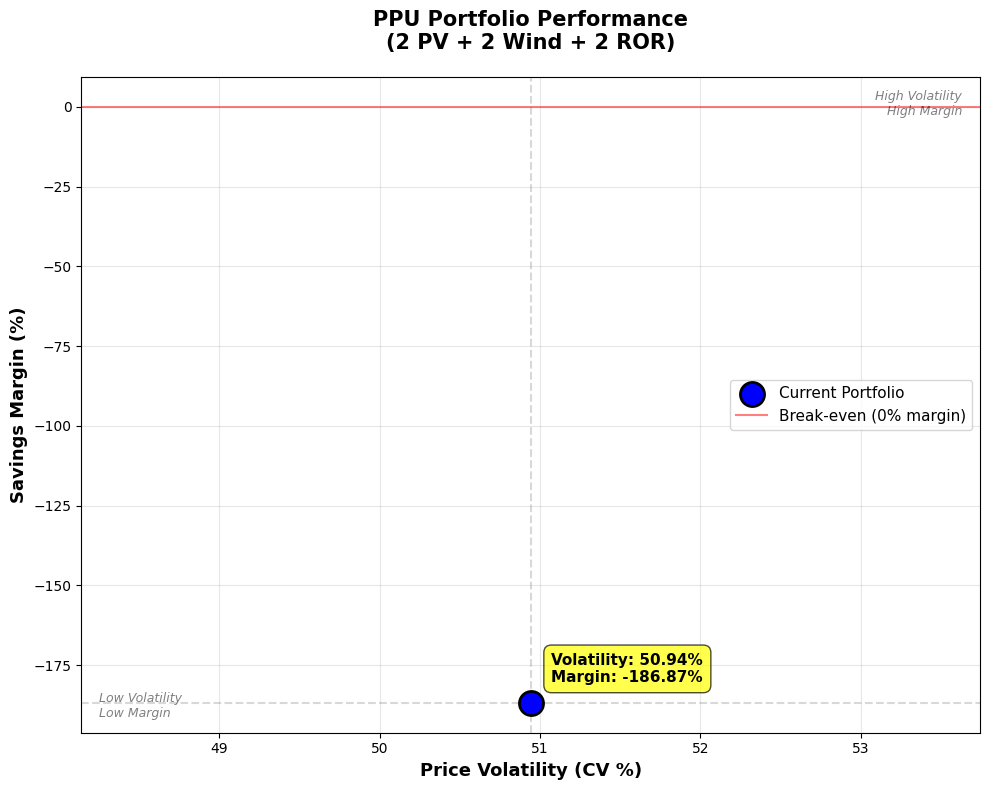


DETAILED COST BREAKDOWN

TOTAL PPU COST:        13,251,516,542.47 CHF
SPOT-ONLY COST:        4,619,397,281.07 CHF
SAVINGS:               -8,632,119,261.40 CHF (-186.87%)


In [10]:
# Visualize the portfolio coordinate
import matplotlib.pyplot as plt

# Extract cost data from pipeline results
cost_summary = pipeline_results['cost_summary']
portfolio_result = pipeline_results['portfolio_result']

for tech_type, costs in cost_summary.items():
    print(f"\n{tech_type}:")
    print(f"  Production Cost:    {costs['production_cost_CHF']:>15,.2f} CHF")
    print(f"  Spot Purchases:     {costs['spot_buy_cost_CHF']:>15,.2f} CHF")
    print(f"  Spot Sales:        ({costs['spot_sell_revenue_CHF']:>15,.2f}) CHF")
    print(f"  Net Cost:           {costs['net_cost_CHF']:>15,.2f} CHF")


fig, ax = plt.subplots(figsize=(10, 8))

# Plot the portfolio point
ax.scatter(portfolio_result['x_volatility_pct'], portfolio_result['y_margin_pct'], 
          s=300, c='blue', marker='o', edgecolors='black', linewidth=2, 
          label='Current Portfolio', zorder=5)

# Add labels
ax.annotate(f"Volatility: {portfolio_result['x_volatility_pct']:.2f}%\nMargin: {portfolio_result['y_margin_pct']:.2f}%",
           xy=(portfolio_result['x_volatility_pct'], portfolio_result['y_margin_pct']),
           xytext=(15, 15), textcoords='offset points',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
           fontsize=11, fontweight='bold')

# Add reference lines
ax.axhline(y=portfolio_result['y_margin_pct'], color='gray', linestyle='--', alpha=0.3)
ax.axvline(x=portfolio_result['x_volatility_pct'], color='gray', linestyle='--', alpha=0.3)
ax.axhline(y=0, color='red', linestyle='-', alpha=0.5, label='Break-even (0% margin)')

# Styling
ax.set_xlabel('Price Volatility (CV %)', fontsize=13, fontweight='bold')
ax.set_ylabel('Savings Margin (%)', fontsize=13, fontweight='bold')
ax.set_title('PPU Portfolio Performance\n(2 PV + 2 Wind + 2 ROR)', 
            fontsize=15, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=11)

# Add quadrant labels
ax.text(0.98, 0.98, 'High Volatility\nHigh Margin', 
       transform=ax.transAxes, ha='right', va='top',
       fontsize=9, style='italic', alpha=0.5)
ax.text(0.02, 0.02, 'Low Volatility\nLow Margin', 
       transform=ax.transAxes, ha='left', va='bottom',
       fontsize=9, style='italic', alpha=0.5)

plt.tight_layout()
plt.show()

# Print detailed breakdown
print("\n" + "=" * 80)
print("DETAILED COST BREAKDOWN")
print("=" * 80)


print("\n" + "=" * 80)
print(f"TOTAL PPU COST:        {portfolio_result['total_cost_CHF']:>15,.2f} CHF")
print(f"SPOT-ONLY COST:        {portfolio_result['spot_only_cost_CHF']:>15,.2f} CHF")
print(f"SAVINGS:               {portfolio_result['savings_CHF']:>15,.2f} CHF ({portfolio_result['y_margin_pct']:+.2f}%)")
print("=" * 80)

## PPU and Storage Evolution Visualization

These functions allow you to analyze the behavior of your PPU portfolio over time:

### PPU Evolution (`visualize_ppu_evolution`)
Visualize production, spot market transactions, and net energy flow for:
- **All PPUs**: Stacked area chart showing relative contribution of each technology
- **Individual PPU**: Detailed 3-panel view showing production, spot transactions, and net flow

### Storage Evolution (`visualize_storage_evolution`)
Visualize storage levels over time showing:
- Storage capacity vs. current level
- State of Charge (SoC) percentage
- Target SoC reference line
- Statistics: initial, final, min, max, and average SoC

### Time Range Filtering
Both functions support time range filtering:
- Full year: `time_range=None` (default)
- First week: `time_range=(0, 672)` (7 days × 96 timesteps/day)
- First month: `time_range=(0, 2880)` (30 days × 96 timesteps/day)
- Summer months: `time_range=(12096, 21024)` (June-August)


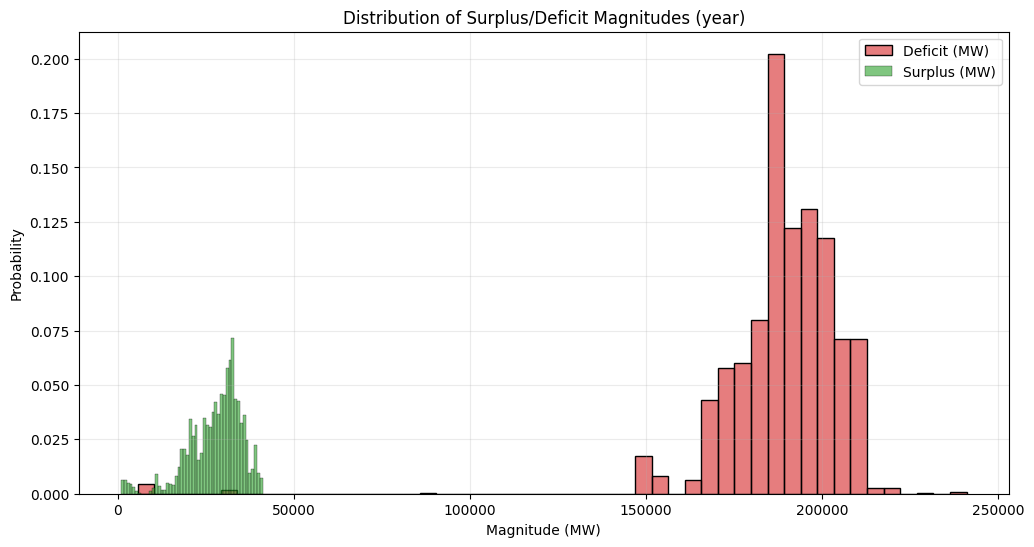

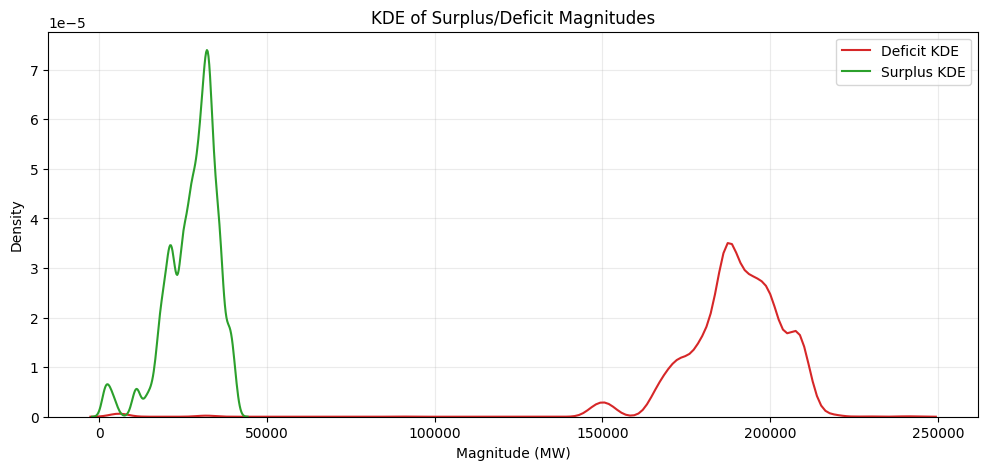

=== Surplus/Deficit Summary ===
Timesteps with deficit: 14,142
Timesteps with surplus: 20,991
From pipeline stats (epsilon=1e-06):
  deficit count (overflow_count): 15019
  surplus count:                 20114
  balanced count:                0
  shares: deficit 42.7%, surplus 57.3%, balanced 0.0%

Magnitude (MW) percentiles:
  P50: deficit 189730.93 MW | surplus  29534.79 MW
  P75: deficit 199149.82 MW | surplus  33003.62 MW
  P90: deficit 207142.38 MW | surplus  35996.70 MW
  P95: deficit 209233.04 MW | surplus  38007.80 MW
  P99: deficit 211198.61 MW | surplus  40209.77 MW


In [11]:
# Surplus/Deficit distribution over the year
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Try to extract a net grid balance series from available results
# Convention (from pipeline):
#   balance_MW > +epsilon  => deficit (we had to buy / unmet by supply)
#   balance_MW < -epsilon  => surplus (we could sell / had extra)

def find_balance_series(epsilon=1e-6):
    # 1) Prefer explicit keys in pipeline_results
    if isinstance(pipeline_results, dict):
        for k in ["overflow_series", "overflow_MW", "grid_balance", "balance_MW"]:
            s = pipeline_results.get(k, None)
            if s is not None:
                try:
                    s = pd.Series(s)
                    s.name = "balance_MW"
                    return s
                except Exception:
                    pass
        # 2) A dispatch DataFrame with a balance/overflow column
        for k in ["dispatch", "timeseries", "ts", "df"]:
            obj = pipeline_results.get(k, None)
            if isinstance(obj, pd.DataFrame):
                for col in obj.columns:
                    if col.lower() in ("overflow_mw", "balance_mw", "grid_balance"):
                        s = obj[col].copy()
                        s.name = "balance_MW"
                        return s
        # 3) Technology_volume may have a balance if present
        tv = pipeline_results.get("technology_volume")
        if isinstance(tv, dict):
            # If a dedicated key exists
            for k in ["grid_balance", "balance_MW", "overflow_MW"]:
                if k in tv and hasattr(tv[k], "__len__"):
                    try:
                        s = pd.Series(tv[k])
                        s.name = "balance_MW"
                        return s
                    except Exception:
                        pass
    # 4) Nothing found
    return None

def _to_1d(arr):
    """Convert arr to 1D float array; if 2D, aggregate across columns."""
    a = np.asarray(arr)
    if a.ndim == 1:
        return a.astype(float)
    if a.ndim >= 2:
        # Sum across last axis to aggregate any sub-components
        a = np.sum(a, axis=-1)
        return a.astype(float)
    return np.array([], dtype=float)

def compute_balance_from_spot(epsilon=1e-6):
    """Fallback: reconstruct balance from aggregated spot transactions across PPUs.
    Positive => deficit (net bought), Negative => surplus (net sold).
    Uses data_shapes['spot'] for canonical length when available.
    """
    if not isinstance(pipeline_results, dict):
        return None
    tv = pipeline_results.get("technology_volume")
    shapes = pipeline_results.get("data_shapes", {})
    spot_len = int(shapes.get("spot", 0))
    if not isinstance(tv, dict) or spot_len <= 0:
        return None

    bought_total = np.zeros(spot_len, dtype=float)
    sold_total = np.zeros(spot_len, dtype=float)

    def _fit_len(arr, L):
        arr = _to_1d(arr)
        if arr.size == L:
            return arr
        if arr.size == 0:
            return np.zeros(L, dtype=float)
        if arr.size > L:
            return arr[:L]
        # pad
        out = np.zeros(L, dtype=float)
        out[:arr.size] = arr
        return out

    for name, rec in tv.items():
        if not isinstance(rec, dict):
            continue
        if "spot_bought" in rec:
            bought_total += _fit_len(rec["spot_bought"], spot_len)
        if "spot_sold" in rec:
            sold_total += _fit_len(rec["spot_sold"], spot_len)

    balance = bought_total - sold_total
    return pd.Series(balance, name="balance_MW")

balance = find_balance_series(epsilon)
if balance is None:
    balance = compute_balance_from_spot(epsilon)

if balance is None:
    print("No balance/overflow time series found or reconstructable from spot transactions.\n"
          "Please ensure the pipeline exports a 'balance_MW' or 'overflow_MW' series, or per-PPU spot arrays.")
else:
    # Clean to numpy for speed
    x = balance.values.astype(float)
    # Split magnitudes for readability
    deficit_mag = x[x > epsilon]                # MW above +epsilon
    surplus_mag = -x[x < -epsilon]              # MW below -epsilon, take magnitude

    # Summary from pipeline stats if available
    stats = None
    if isinstance(pipeline_results, dict):
        stats = pipeline_results.get("pipeline_stats")
        if stats is None:
            # Some runs store stats under Technology_volume['__pipeline_stats__']
            tv = pipeline_results.get("technology_volume")
            if isinstance(tv, dict):
                stats = tv.get("__pipeline_stats__")
    
    # Plot distributions
    plt.figure(figsize=(12, 6))
    bins = 50
    sns.histplot(deficit_mag, bins=bins, color="#d62728", alpha=0.6, stat="probability", label="Deficit (MW)")
    sns.histplot(surplus_mag, bins=bins, color="#2ca02c", alpha=0.6, stat="probability", label="Surplus (MW)")
    plt.xlabel("Magnitude (MW)")
    plt.ylabel("Probability")
    plt.title("Distribution of Surplus/Deficit Magnitudes (year)")
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.show()

    # Optional: KDE overlay for smooth shape
    plt.figure(figsize=(12, 5))
    if len(deficit_mag) > 1:
        sns.kdeplot(deficit_mag, color="#d62728", label="Deficit KDE")
    if len(surplus_mag) > 1:
        sns.kdeplot(surplus_mag, color="#2ca02c", label="Surplus KDE")
    plt.xlabel("Magnitude (MW)")
    plt.ylabel("Density")
    plt.title("KDE of Surplus/Deficit Magnitudes")
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.show()

    # Print quick stats
    print("=== Surplus/Deficit Summary ===")
    print(f"Timesteps with deficit: {deficit_mag.size:,}")
    print(f"Timesteps with surplus: {surplus_mag.size:,}")
    if stats:
        oc = stats.get("overflow_count")
        sc = stats.get("surplus_count")
        bc = stats.get("balanced_count")
        total = (oc or 0) + (sc or 0) + (bc or 0)
        print(f"From pipeline stats (epsilon={epsilon}):")
        print(f"  deficit count (overflow_count): {oc}")
        print(f"  surplus count:                 {sc}")
        print(f"  balanced count:                {bc}")
        if total:
            print(f"  shares: deficit {oc/total:.1%}, surplus {sc/total:.1%}, balanced {bc/total:.1%}")

    print("\nMagnitude (MW) percentiles:")
    for p in [50, 75, 90, 95, 99]:
        dm = np.percentile(deficit_mag, p) if deficit_mag.size else 0.0
        sm = np.percentile(surplus_mag, p) if surplus_mag.size else 0.0
        print(f"  P{p:>2}: deficit {dm:9.2f} MW | surplus {sm:9.2f} MW")

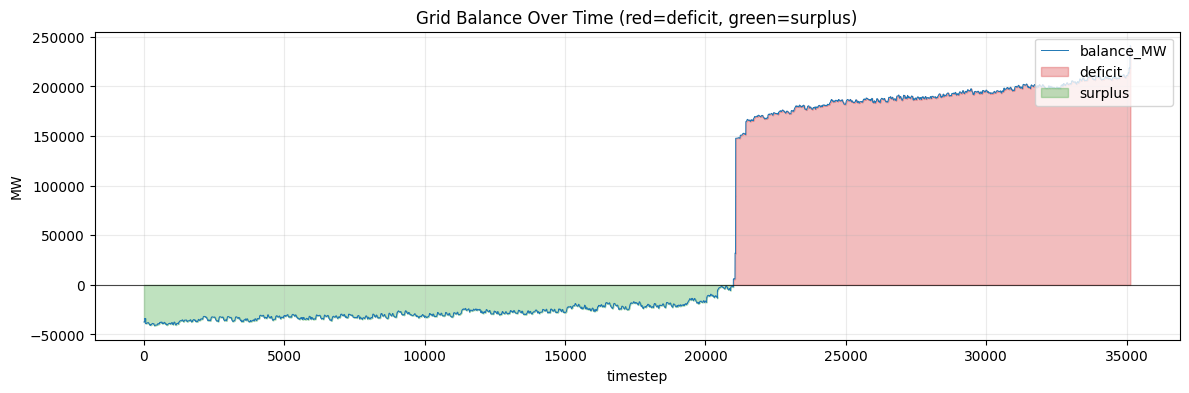

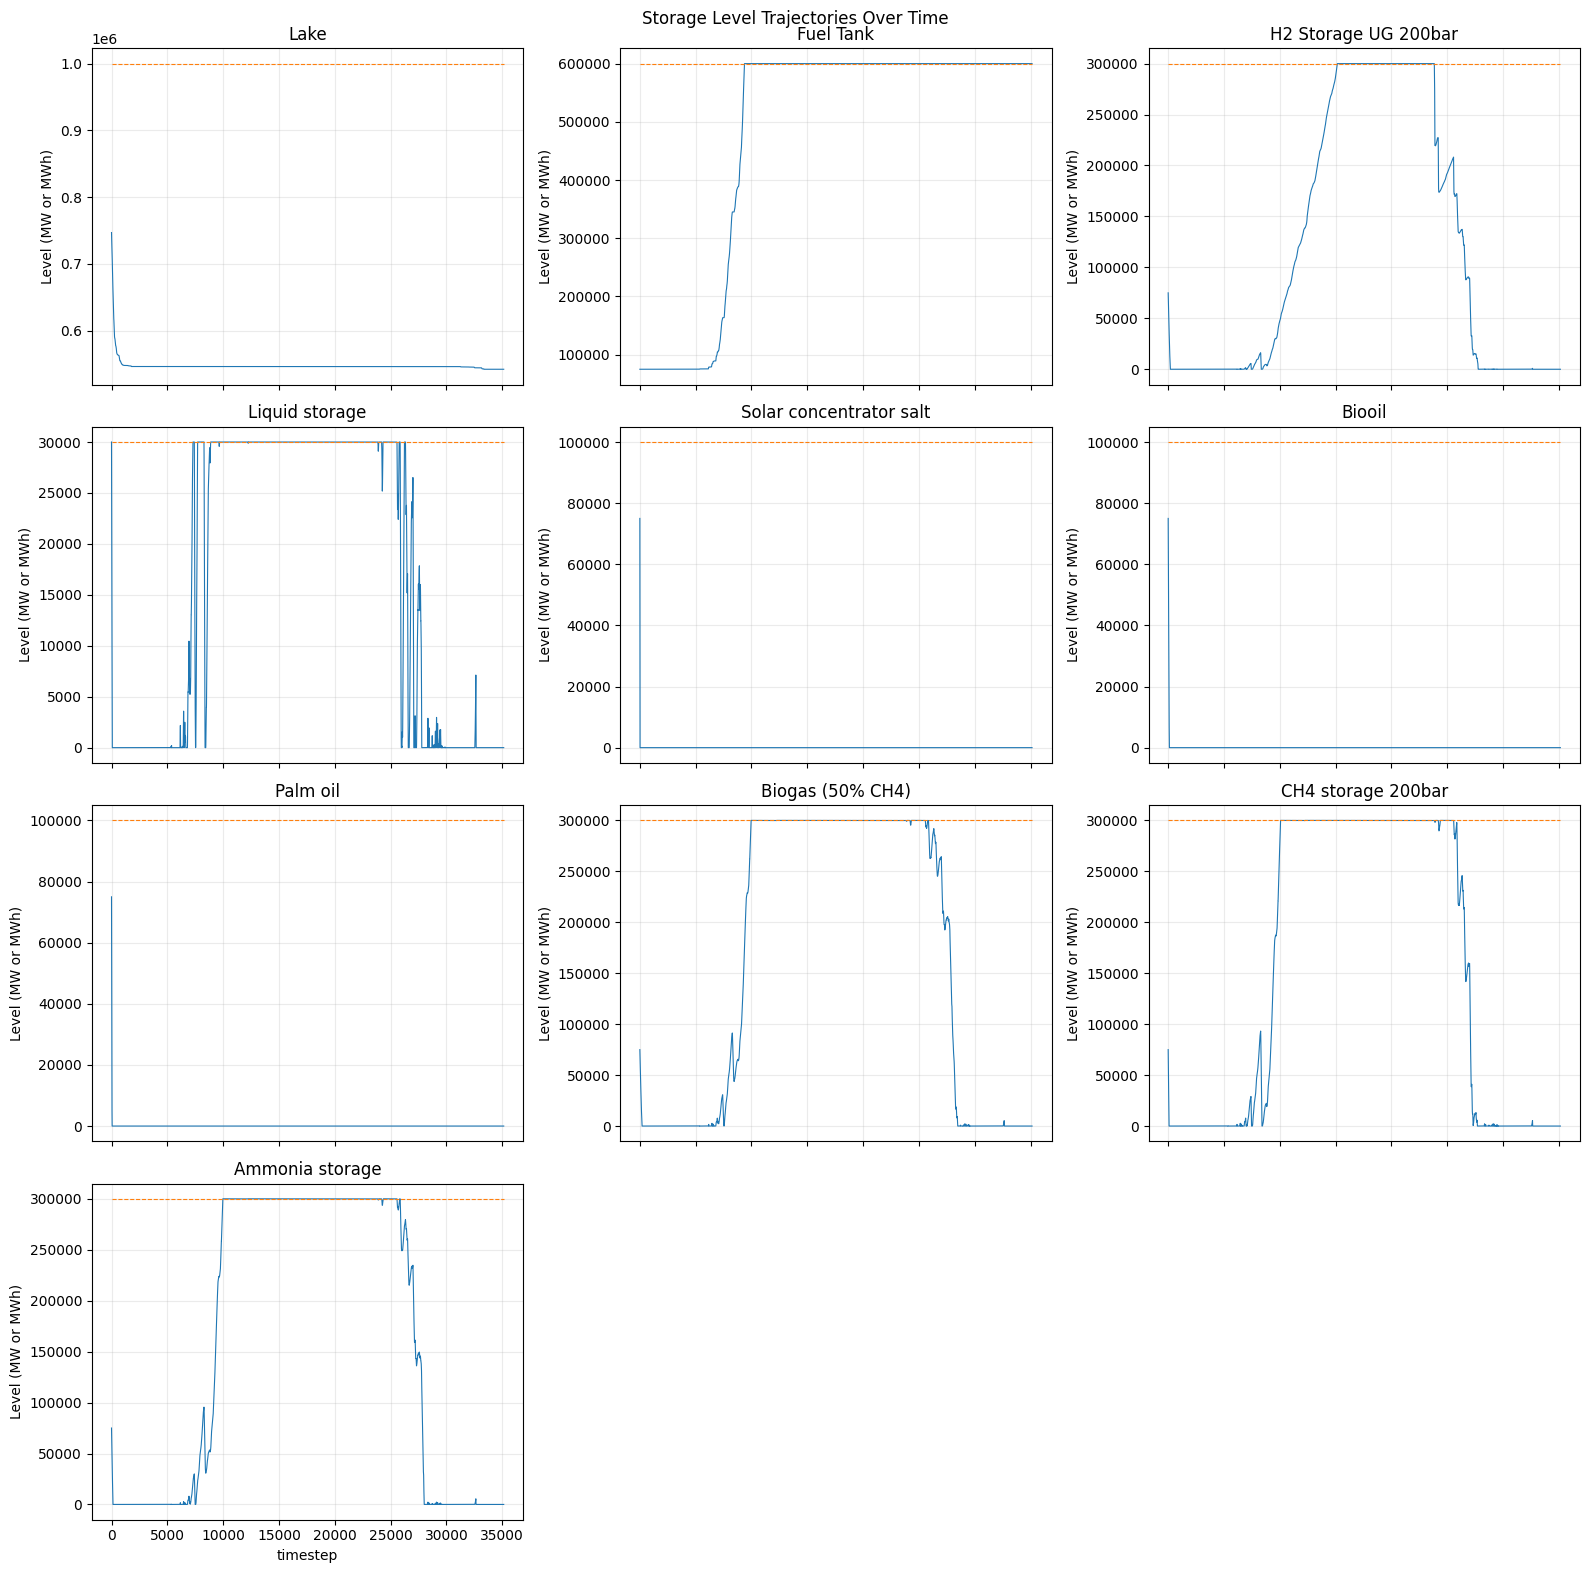

In [12]:
# Time-series: deficit/surplus over time and storage level trajectories
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reuse epsilon if defined, else fallback
_eps = globals().get('epsilon', 1e-6)

# Get balance time series from prior cell if available; else try to reconstruct
b = None
try:
    b = balance  # from previous cell
except NameError:
    pass

if b is None:
    # Try helper functions defined in the previous cell
    try:
        b = find_balance_series(_eps)
        if b is None:
            b = compute_balance_from_spot(_eps)
    except Exception:
        b = None

if b is None:
    print("No balance/overflow time series found or reconstructable. Skipping time-series plot.")
else:
    b = pd.Series(b).astype(float)
    N = len(b)
    t_idx = np.arange(N)

    # Plot balance over time with shaded regions
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(t_idx, b.values, color="#1f77b4", linewidth=0.7, label="balance_MW")

    # Shade deficit (b > +eps) in red and surplus (b < -eps) in green
    ax.fill_between(t_idx, 0, b.values, where=(b.values > _eps), color="#d62728", alpha=0.3, label="deficit")
    ax.fill_between(t_idx, 0, b.values, where=(b.values < -_eps), color="#2ca02c", alpha=0.3, label="surplus")

    ax.axhline(0, color="black", linewidth=0.8, alpha=0.7)
    ax.set_title("Grid Balance Over Time (red=deficit, green=surplus)")
    ax.set_xlabel("timestep")
    ax.set_ylabel("MW")
    ax.legend(loc="upper right")
    ax.grid(True, alpha=0.25)
    plt.show()

# Storage level trajectories
# We reconstruct each storage's level over time from its delta history and final current_value.

def reconstruct_storage_series(rec, length):
    """Rebuild storage level time series from (t, delta) history and final current_value.
    Returns (level, capacity, name)."""
    name = rec.get('storage') or rec.get('name') or 'Storage'
    cap = float(rec.get('value', 0.0))
    final_val = float(rec.get('current_value', 0.0))
    history = rec.get('history') or []

    deltas = np.zeros(length, dtype=float)
    for item in history:
        try:
            t, delta = item
            ti = int(t)
            if 0 <= ti < length:
                deltas[ti] += float(delta)
        except Exception:
            continue
    baseline = final_val - float(deltas.sum())  # initial level
    level = baseline + np.cumsum(deltas)
    # Optional clamp for visualization
    if cap > 0:
        level = np.clip(level, 0.0, cap)
    return level, cap, name

# Build plots if raw_energy_storage is present
have_storage = 'raw_energy_storage' in globals()
if not have_storage:
    print("raw_energy_storage not found in this kernel; skipping storage plots.")
else:
    try:
        storages = raw_energy_storage
    except Exception:
        storages = None

    if not isinstance(storages, (list, tuple)) or len(storages) == 0:
        print("No storage records available; skipping storage plots.")
    else:
        # Determine time length from balance if present; otherwise infer from longest history index
        if b is not None:
            L = len(b)
        else:
            max_t = 0
            for rec in storages:
                hist = rec.get('history') or []
                for item in hist:
                    try:
                        ti = int(item[0])
                        if ti > max_t:
                            max_t = ti
                    except Exception:
                        pass
            L = max_t + 1 if max_t > 0 else 0

        if L == 0:
            print("Could not infer time length for storage histories; skipping storage plots.")
        else:
            t_idx = np.arange(L)
            n = len(storages)
            ncols = 3
            nrows = int(np.ceil(n / ncols))
            fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4 * nrows), sharex=True)
            if nrows * ncols == 1:
                axes = np.array([axes])
            axes = axes.reshape(nrows, ncols)

            for i, rec in enumerate(storages):
                r = i // ncols
                c = i % ncols
                ax = axes[r, c]
                series, cap, name = reconstruct_storage_series(rec, L)
                ax.plot(t_idx, series, color="#1f77b4", linewidth=0.8)
                if cap > 0:
                    ax.hlines(cap, t_idx[0], t_idx[-1], colors="#ff7f0e", linestyles="--", linewidth=0.8, label="capacity")
                ax.set_title(f"{name}")
                ax.set_ylabel("Level (MW or MWh)")
                ax.grid(True, alpha=0.25)
                if r == nrows - 1:
                    ax.set_xlabel("timestep")

            # Hide any unused subplots
            for j in range(n, nrows * ncols):
                r = j // ncols
                c = j % ncols
                axes[r, c].axis('off')

            fig.suptitle("Storage Level Trajectories Over Time", y=0.98)
            plt.tight_layout()
            plt.show()

In [13]:
# Quick summary stats for balance and storage utilization
import numpy as np
import pandas as pd

# Assumed timestep length in hours (15 minutes)
dt_hours = 0.25

# Balance summary
if 'b' in locals() and b is not None:
    bb = pd.Series(b).astype(float)
    deficit = bb[bb > _eps]
    surplus = -bb[bb < -_eps]
    stats_rows = [
        ["timesteps_deficit", int(deficit.size)],
        ["timesteps_surplus", int(surplus.size)],
        ["total_deficit_MWh", float(deficit.sum() * dt_hours)],
        ["total_surplus_MWh", float(surplus.sum() * dt_hours)],
        ["mean_deficit_MW", float(deficit.mean() if deficit.size else 0.0)],
        ["mean_surplus_MW", float(surplus.mean() if surplus.size else 0.0)],
        ["p95_deficit_MW", float(np.percentile(deficit, 95) if deficit.size else 0.0)],
        ["p95_surplus_MW", float(np.percentile(surplus, 95) if surplus.size else 0.0)],
    ]
    balance_summary = pd.DataFrame(stats_rows, columns=["metric", "value"])
    print("Balance summary (assuming 15-min steps):")
    display(balance_summary)
else:
    print("No balance series available for summary.")

# Storage utilization summary
if 'raw_energy_storage' in globals() and isinstance(raw_energy_storage, (list, tuple)) and len(raw_energy_storage) > 0:
    def reconstruct_storage_series(rec, length):
        cap = float(rec.get('value', 0.0))
        final_val = float(rec.get('current_value', 0.0))
        history = rec.get('history') or []
        deltas = np.zeros(length, dtype=float)
        for item in history:
            try:
                t, delta = item
                ti = int(t)
                if 0 <= ti < length:
                    deltas[ti] += float(delta)
            except Exception:
                pass
        baseline = final_val - float(deltas.sum())
        level = baseline + np.cumsum(deltas)
        if cap > 0:
            level = np.clip(level, 0.0, cap)
        return level, cap

    # Determine L (prefer from balance)
    if 'b' in locals() and b is not None:
        L = len(b)
    else:
        max_t = 0
        for rec in raw_energy_storage:
            for item in (rec.get('history') or []):
                try:
                    ti = int(item[0])
                    if ti > max_t:
                        max_t = ti
                except Exception:
                    pass
        L = max_t + 1 if max_t > 0 else 0

    rows = []
    for rec in raw_energy_storage:
        name = rec.get('storage') or rec.get('name') or 'Storage'
        level, cap = reconstruct_storage_series(rec, L) if L > 0 else (np.array([]), float(rec.get('value', 0.0)))
        if level.size:
            pct_full = float(np.mean(level >= 0.99 * cap) * 100.0) if cap > 0 else 0.0
            pct_empty = float(np.mean(level <= 0.01 * cap) * 100.0) if cap > 0 else 0.0
            rows.append({
                'storage': name,
                'capacity': cap,
                'initial': float(level[0]),
                'final': float(level[-1]),
                'min': float(level.min()),
                'mean': float(level.mean()),
                'max': float(level.max()),
                '%time_near_full(>=99%)': pct_full,
                '%time_near_empty(<=1%)': pct_empty,
            })
        else:
            rows.append({
                'storage': name,
                'capacity': cap,
                'initial': np.nan,
                'final': np.nan,
                'min': np.nan,
                'mean': np.nan,
                'max': np.nan,
                '%time_near_full(>=99%)': np.nan,
                '%time_near_empty(<=1%)': np.nan,
            })

    storage_summary = pd.DataFrame(rows)
    display(storage_summary.sort_values('storage').reset_index(drop=True))
else:
    print("No storage records available for summary.")

Balance summary (assuming 15-min steps):


,metric,value
0,timesteps_deficit,1.414200e+04
1,timesteps_surplus,2.099100e+04
2,total_deficit_MWh,6.677994e+08
3,total_surplus_MWh,1.465302e+08
4,mean_deficit_MW,1.888840e+05
5,mean_surplus_MW,2.792248e+04
6,p95_deficit_MW,2.092330e+05
7,p95_surplus_MW,3.800780e+04


,storage,capacity,initial,final,min,mean,max,%time_near_full(>=99%),%time_near_empty(<=1%)
0,Ammonia storage,300000.0,75000.000000,0.000000e+00,0.000000e+00,155056.199332,300000.000000,44.542168,39.933965
1,Biogas (50% CH4),300000.0,75000.000000,0.000000e+00,0.000000e+00,158392.099780,300000.000000,44.727180,38.206245
2,Biooil,100000.0,75000.000000,2.910383e-11,2.910383e-11,105.580171,75000.000000,0.000000,99.721060
3,CH4 storage 200bar,300000.0,75000.000000,0.000000e+00,0.000000e+00,148474.965752,300000.000000,43.887513,41.547833
4,Fuel Tank,600000.0,75000.000000,6.000000e+05,7.500000e+04,475617.879206,600000.000000,73.378305,0.000000
5,H2 Storage UG 200bar,300000.0,75000.000000,0.000000e+00,0.000000e+00,115066.103829,300000.000000,24.862665,42.438733
6,Lake,1000000.0,746939.888349,5.421388e+05,5.421388e+05,547199.202174,746939.888349,0.000000,0.000000
7,Liquid storage,30000.0,30000.000000,0.000000e+00,0.000000e+00,16321.907263,30000.000000,49.753793,39.501324
8,Palm oil,100000.0,75000.000000,1.455192e-11,1.455192e-11,53.607720,75000.000000,0.000000,99.866223
9,Solar concentrator salt,100000.0,75000.000000,0.000000e+00,0.000000e+00,9.232604,75000.000000,0.000000,99.977229


In [14]:
# Diagnostic: Why is Lake not filling?
# Check which PPUs can input to Lake

import pandas as pd

print("=== Lake Filling Diagnostic ===\n")

# 1. Check Lake storage status
lake_storage = next((s for s in raw_energy_storage if s['storage'] == 'Lake'), None)
if lake_storage:
    print(f"Lake Storage:")
    print(f"  Capacity: {lake_storage['value']:,.0f} MW")
    print(f"  Initial: {lake_storage.get('base_value', 'N/A')} MW")
    print(f"  Current: {lake_storage['current_value']:,.0f} MW")
    print(f"  Available space: {lake_storage['value'] - lake_storage['current_value']:,.0f} MW")
    print(f"  Extracted by: {lake_storage.get('extracted_by', [])}")
else:
    print("Lake storage NOT FOUND!")

print("\n" + "="*60)

# 2. Check which PPUs in portfolio can input to Lake
print("\n2. PPUs that can INPUT TO Lake:")
lake_input_ppus = []
for _, row in ppu_dictionary.iterrows():
    can_input = row.get('can_input_to', []) or []
    if isinstance(can_input, str):
        can_input = eval(can_input) if can_input.startswith('[') else [can_input]
    if 'Lake' in can_input:
        lake_input_ppus.append({
            'PPU_Name': row['PPU_Name'],
            'PPU_Extract': row.get('PPU_Extract', 'N/A'),
            'can_input_to': can_input,
            'Chain_Efficiency': row.get('Chain_Efficiency', 1.0)
        })
        print(f"  - {row['PPU_Name']} (Extract: {row.get('PPU_Extract', 'N/A')}, Efficiency: {row.get('Chain_Efficiency', 1.0):.2%})")

if not lake_input_ppus:
    print("  ⚠️  NO PPUs found that can input to Lake!")
    print("\n  Possible reasons:")
    print("    1. HYD_S PPU not added to portfolio")
    print("    2. PPU_STORAGE_MAPPING incorrectly configured")
    print("    3. can_input_to field not properly set during PPU creation")

print("\n" + "="*60)

# 3. Check Store-type PPUs
print("\n3. All 'Store' PPUs in portfolio:")
store_ppus = ppu_dictionary[ppu_dictionary['PPU_Extract'] == 'Store']
if len(store_ppus) > 0:
    for _, row in store_ppus.iterrows():
        can_input = row.get('can_input_to', []) or []
        if isinstance(can_input, str):
            can_input = eval(can_input) if can_input.startswith('[') else [can_input]
        print(f"  - {row['PPU_Name']}: can_input_to = {can_input}")
else:
    print("  No Store PPUs found!")

print("\n" + "="*60)

# 4. Check if HYD_S is in the portfolio
print("\n4. Hydro PPUs in portfolio:")
hydro_ppus = [row for _, row in ppu_dictionary.iterrows() if 'HYD' in str(row['PPU_Name'])]
if hydro_ppus:
    for row in hydro_ppus:
        print(f"  - {row['PPU_Name']}")
        print(f"      Extract: {row.get('PPU_Extract', 'N/A')}")
        print(f"      can_extract_from: {row.get('can_extract_from', [])}")
        print(f"      can_input_to: {row.get('can_input_to', [])}")
else:
    print("  ⚠️  No Hydro PPUs found in portfolio!")

print("\n" + "="*60)

# 5. Summary
print("\n=== SUMMARY ===")
print(f"Total surplus timesteps: {surplus_mag.size if 'surplus_mag' in locals() else 'N/A'}")
print(f"PPUs that can fill Lake: {len(lake_input_ppus)}")
print(f"Lake current level: {lake_storage['current_value'] if lake_storage else 'N/A'}")
print(f"Lake capacity: {lake_storage['value'] if lake_storage else 'N/A'}")

if lake_storage and len(lake_input_ppus) == 0:
    print("\n⚠️  PROBLEM: Lake exists but NO PPUs can input to it!")
    print("   → Lake can only be filled by PPUs with 'can_input_to': ['Lake']")
    print("   → Based on PPU_STORAGE_MAPPING, only HYD_S should input to Lake")
    print("   → But HYD_S mapping shows 'input_to': ['Lake'] which is WRONG!")
    print("   → HYD_S should EXTRACT from Lake, not INPUT to Lake")
    print("\n   Solution: Add a PPU that can input to Lake (e.g., natural inflow or pumped hydro)")


=== Lake Filling Diagnostic ===

Lake Storage:
  Capacity: 1,000,000 MW
  Initial: N/A MW
  Current: 542,139 MW
  Available space: 457,861 MW
  Extracted by: ['HYD_S']


2. PPUs that can INPUT TO Lake:
  - HYD_S (Extract: Incidence, Efficiency: 88.00%)


3. All 'Store' PPUs in portfolio:
  No Store PPUs found!


4. Hydro PPUs in portfolio:
  - HYD_S
      Extract: Incidence
      can_extract_from: []
      can_input_to: ['Lake']


=== SUMMARY ===
Total surplus timesteps: 20991
PPUs that can fill Lake: 1
Lake current level: 542138.7903341529
Lake capacity: 1000000


## Lake Filling Issue - Root Cause Analysis

**Problem Found:**
- Lake storage is **NOT filling** during surplus periods
- Current level: 542,139 MW (started at ~747,000 MW, **decreasing** over time)

**Root Cause:**
1. `HYD_S` (Hydroelectric Storage) is marked as `PPU_Extract: 'Incidence'` 
2. `HYD_S` has `can_input_to: ['Lake']` in the configuration
3. BUT `handle_energy_surplus()` only processes PPUs where `PPU_Extract == 'Store'`
4. Since HYD_S is NOT a Store PPU, it **never actually charges Lake**

**Architecture Issue:**
According to the code comments and physics:
- `HYD_S` should **EXTRACT from Lake** (discharge water through turbines to generate power)
- `PHS` (Pumped Hydro Storage) should be able to **PUMP INTO Lake** (using excess electricity)
- Natural inflow should fill Lake (like River fills for HYD_R)

**Current Mapping (in `PPU_STORAGE_MAPPING`):**
```python
'HYD_S': {'extract_from': [], 'input_to': ['Lake']},   # WRONG!
'PHS': {'extract_from': ['Lake'], 'input_to': []},      # Partial - can extract but not input
```

**Correct Mapping Should Be:**
```python
'HYD_S': {'extract_from': ['Lake'], 'input_to': []},    # Extract from Lake
'PHS': {'extract_from': ['Lake'], 'input_to': ['Lake']}, # Both extract and pump
# OR add natural inflow as a separate incidence source
```

**Possible Solutions:**

1. **Add PHS to portfolio** (if it exists in your data) and configure it as a Store PPU
2. **Add Lake natural inflow** as an incidence source (like River for run-of-river)
3. **Fix HYD_S mapping** to extract from Lake instead of input to it
4. **Create a pumping PPU** that can convert surplus electricity into Lake storage

In [ ]:
# VERIFICATION: Check if mapping fix is correct and PHS is in portfolio

print("=== LAKE FILLING FIX VERIFICATION ===\n")

# 1. Check current PPU_STORAGE_MAPPING from the code
from calculationsPpuFramework import get_ppu_storage_mapping

try:
    mapping = get_ppu_storage_mapping()
    print("1. PPU_STORAGE_MAPPING (from code):")
    print(f"   HYD_S: {mapping.get('HYD_S', 'NOT FOUND')}")
    print(f"   PHS:   {mapping.get('PHS', 'NOT FOUND')}")
except Exception as e:
    print(f"   Could not load mapping directly: {e}")
    print("   The fix is in calculationsPpuFramework.py:")
    print("   - HYD_S: {'extract_from': ['Lake'], 'input_to': []}")
    print("   - PHS: {'extract_from': ['Lake'], 'input_to': ['Lake']}")

print("\n" + "="*60)

# 2. Check if PHS is in the current portfolio
print("\n2. Check if PHS is in portfolio:")
phs_in_portfolio = any(row['PPU_Name'] == 'PHS' for _, row in ppu_dictionary.iterrows())
if phs_in_portfolio:
    phs_row = ppu_dictionary[ppu_dictionary['PPU_Name'] == 'PHS'].iloc[0]
    print(f"   ✓ PHS found in portfolio")
    print(f"     PPU_Extract: {phs_row.get('PPU_Extract', 'N/A')}")
    print(f"     can_extract_from: {phs_row.get('can_extract_from', [])}")
    print(f"     can_input_to: {phs_row.get('can_input_to', [])}")
    
    # Check if PHS is properly configured as Store
    if phs_row.get('PPU_Extract') == 'Store':
        print(f"   ✓ PHS is configured as 'Store' PPU (can charge during surplus)")
    else:
        print(f"   ⚠️  PHS is NOT configured as 'Store' (PPU_Extract={phs_row.get('PPU_Extract')})")
else:
    print("   ⚠️  PHS NOT in portfolio!")
    print("   → Need to add PHS to ppus_to_add list")
    print("   → Example: ppus_to_add.append({'ppu_name': 'PHS', 'count': 1})")

print("\n" + "="*60)

# 3. Summary and next steps
print("\n3. SUMMARY & NEXT STEPS:")
print("\n   CODE FIX APPLIED:")
print("   ✓ HYD_S now extracts FROM Lake (not inputs)")
print("   ✓ PHS now both extracts from AND inputs to Lake")

if phs_in_portfolio:
    print("\n   STATUS: Lake should now fill during surplus periods!")
    print("   - When surplus occurs, PHS (Store PPU) will pump into Lake")
    print("   - When deficit occurs, HYD_S/PHS (Flex PPUs) will discharge from Lake")
else:
    print("\n   ACTION REQUIRED: Add PHS to portfolio")
    print("   - PHS is the pumped hydro PPU that can charge Lake")
    print("   - Without PHS, Lake can only discharge (via HYD_S)")
    print("\n   To fix, run:")
    print("   ppus_to_add.append({'ppu_name': 'PHS', 'count': 1})")
    print("   Then re-run the pipeline")

print("\n" + "="*60)

# Building a Robust Renewable Portfolio 

> Goal: Design and evaluate a resilient portfolio of Power Production Units (PPUs) that minimizes total cost and downside risk while keeping spot-market dependence low over a 30‑day horizon at 15‑minute resolution.

-> this is exact

## What you will build
- A mixed‑integer optimization that selects integer counts of PPUs by type.
- A simulation that dispatches PPUs and storages at 15‑min steps, producing cost and risk metrics.
- A short report with visuals (efficient frontier, deficit/surplus timelines, storage trajectories).
-> exact all 3 

## Data and assumptions
- Use the same inputs as the pipeline already loaded in this notebook (spot prices, renewable incidence, storage specs, costs). Y
- Timestep: 15 minutes (96 per day). Optimize for a 30‑day horizon. Y but you choose randomnly days, not 15 minutes 
- Scaling: Each additional unit of a PPU type adds linear capacity/production, subject to costs. Y the costs follow the rule 1.0 + 0.1 * for each next PPU. Do not apply this rule to the energy incidence storages. 
- Location/ranking: Respect any location/rank limits already enforced by the pipeline (no duplicate use of the same site where applicable). -> PPU solar and wind are location dependent, the others not 

## Decision variables (integer)
Let x_t ∈ ℕ be the count of PPUs of type t to install/add.
-> exactly. if you want I need the vector of # PPU optimized if that makes sense

## Objective (choose one, then optionally compare)
1) Scalarized risk‑averse cost (recommended for the core exercise):
- Minimize: TotalCost(x) + λ · CVaR_95(NetCost(x)) Y good cost function
- Where TotalCost includes: capitalized or per‑unit regularizer + expected operating costs − expected savings. Y. the costs are already given
- CVaR_95 is computed on 30‑day net cost distribution from scenarios (see below).  Y. 

2) Pareto frontier (advanced):
- Simultaneously study (TotalCost, CVaR_95) across a grid of λ values and plot the Pareto set.
Y but I feel like we should do this later 

## Constraints (include at least)
- Integer counts: x_t ∈ {0,1,2,…}. Y
- Feasibility: Dispatch must satisfy energy balance each step:
  production + imports − exports − storage_delta = demand. Y 
- Storage limits: 0 ≤ SOC_s(t) ≤ Capacity_s(x). Y where capactiy is function of number of PPU that can contribute 
- Optional guardrails:
  - Diversity: sum of top‑1 tech share ≤ θ. Y. you can use HHI index for that 
  - Budget: TotalCost(x) ≤ B. N. disregard

## Scenarios and evaluation
- Build an ensemble of scenarios for the 30‑day horizon at 15‑min resolution:
  - Option A (quick): Randomly sample days across the year and concatenate to length 30 days. Y we start with this 
  - Option B (robust): Use forecast models with noise/stress variants (price spikes, low renewable periods). N. we don't do that yet 
- For each candidate x:
  - Run the pipeline to simulate dispatch and compute per‑scenario NetCost. Y. 
  - Aggregate metrics: mean NetCost, CVaR_95(NetCost), spot MWh bought/sold, storage cycles, % time near full/empty. Y. 

## Deliverables
1) Notebook sections:
   - Setup: data, helper functions, scenario generator.
   - Optimization: solver call (you may use Gurobi or a heuristic if licensing blocks).
   - Evaluation: plots of efficient frontier, deficit/surplus over time, storage trajectories (already provided in previous cells), and a summary table.
2) Short write‑up (10–15 lines):
   - Your chosen objective and λ.
   - Key constraints and why.
   - Best portfolio x and its metrics (mean cost, CVaR, spot usage, storage utilization).

## Step‑by‑step tasks
1) Define the decision set T and bounds for x_t (e.g., 0–10 per type).
2) Implement a small per‑unit cost regularizer to avoid unbounded solutions (e.g., cost_t · (1 + 0.1·k) for the kth unit).
3) Implement scenario generation for a 30‑day horizon at 15‑min resolution.
4) For a given x, run the dispatch simulation and compute NetCost per scenario.
5) Implement CVaR_95 and TotalCost; assemble the scalarized objective for a chosen λ.
6) Solve for x (integer). If Gurobi isn’t available, use a genetic algorithm or grid/random search for a baseline.
7) Produce the efficient frontier by sweeping λ and re‑solving.
8) Visualize results: frontier plot, best‑x timeline plots (balance and storages), and the summary tables.
